## **Analyzing Terrorist Incidents in Somalia**

In [1211]:
# Libraries for data manipulation, cleaning, and basic analysis
import pandas as pd
import numpy as np

# For static visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from PIL import Image

# For generating word clouds
from wordcloud import WordCloud
from folium.plugins import HeatMap
from IPython.display import display

# For handling geospatial data
import geopandas as gpd  # For geospatial data operations
from shapely.geometry import Point  # For creating geometry objects for maps
import folium  # For creating interactive maps
from folium.plugins import HeatMap  # Heatmap for density plotting on maps
from folium.plugins import MarkerCluster

# To suppress warnings that may clutter the output
import warnings
warnings.filterwarnings("ignore")

## **Read the Data**

In [1212]:
data = pd.read_csv("GTD dataset.csv", encoding='ISO-8859-1')

In [1213]:
df = data.copy()

In [1214]:
df.head()

,eventid,iyear,imonth,iday,extended,provstate,city,latitude,longitude,location,...,weapdetail,nkill,nwound,nkillter,nwoundte,property,propextent,propextent_txt,propvalue,propcomment
0,1.980000e+11,1975,3,25,1,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,NaN,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN
1,1.980000e+11,1980,4,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,NaN,1.0,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN
2,1.980000e+11,1981,1,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,Explosive,0.0,2.0,NaN,NaN,1,NaN,NaN,NaN,NaN
3,1.980000e+11,1981,1,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,Explosive,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
4,1.980000e+11,1981,1,0,0,Banaadir,Mogadishu,2.059819,45.326115,NaN,...,Explosive,NaN,NaN,NaN,NaN,1,4.0,Unknown,NaN,NaN


## **Data Cleaning**

### **Understand the Data**

In [1215]:
print(f"""   
- The dataset covers {df.provstate.nunique():,} regions and {df.city.nunique():,} cities across Somalia.
- It includes data on terrorist attacks from {df.iyear.nunique()} years, ranging from {df.iyear.min()} to {df.iyear.max()}.
- Overall, {df.index.nunique():,} terrorist attacks are recorded.
- This results in approximately {int(df['nkill'].sum()) + int(df['nwound'].sum()):,} casualties. 
- Which include {int(df.nkill.sum()):,} deaths and {int(df.nwound.sum()):,} injuries.
""")

   
- The dataset covers 19 regions and 319 cities across Somalia.
- It includes data on terrorist attacks from 38 years, ranging from 1975 to 2020.
- Overall, 5,315 terrorist attacks are recorded.
- This results in approximately 24,390 casualties. 
- Which include 13,168 deaths and 11,222 injuries.



#### **Renaming the columns**

In [1216]:
# Clean columns by renaming them
df.rename(columns={
    'iyear': 'year', 'imonth': 'month', 'iday': 'day', 'success': 'success', 'suicide': 'suicide',
    'provstate': 'region', 'city': 'city', 'latitude': 'lat', 'longitude': 'long', 'summary': 'summary',
    'attacktype1_txt': 'attack_type', 'targtype1_txt': 'target_type', 'targsubtype1_txt': 'target_subtype', 
    'new_target': 'target',  'natlty1_txt': 'nationality', 'gname': 'group_name', 'claimmode_txt': 'claim_mode',
    'weaptype1_txt': 'weapon_type', 'weapsubtype1_txt': 'weapon_subtype', 'weapdetail' : 'weapon_detail',
    'nkill': 'killed', 'nwound': 'wounded', 'nkillter': 'terr_killed', 'nwoundte': 'terr_wounded',
    'target1': 'target1', 'propextent_txt': 'propextent', 'extended': 'extended'
}, inplace=True)

In [1217]:
# Reorganize columns
new_column_order = [
    'eventid','year', 'month', 'day', 'region', 'city', 'location','lat', 'long', 'attack_type', 'suicide', 'success',
    'weapon_type', 'weapon_subtype', 'weapon_detail', 'target_type', 'target_subtype', 'target', 
    'killed', 'wounded', 'nationality', 'group_name', 'terr_killed', 'terr_wounded', 'claim_mode', 
    'propextent', 'summary', 'motive', 'extended'
]
# Reassign columns in the new order
df = df[new_column_order]

In [1218]:
# Dictionary to rename and merge terrorist group names
group_rename_dict = {
    'Front for the Liberation of the French Somali Coast': 'FSCLF',
    'Somali Salvation Front (SSF)': 'SSF',
    'Somali Salvation Democratic Front (SSDF)': 'SSDF',
    'Somali National Movement': 'SNM',
    'United Somali Congress': 'USC',
    'Somali Patriotic Movement': 'SPM',
    'Somali National Alliance': 'SNA',

    'Aidid Militia': 'Aideed Militia',
    'Gunmen loyal to Mohammad Farah Aideed': 'Aideed Militia',
    'Supporters of Ali Mahdi Mohammed': 'Ali Mahdi Supporters',
    'Somali Guerrillas': 'Somali Guerrillas',
    'U/I Somali Militiamen': 'Somali Militiamen',
    'Mousa Ismail sub-clan': 'Clan Militias',
    'Habr Gedir Clan': 'Clan Militias',
    'Rahanwein Resistance Army (RRA)': 'Clan Militias',
    'Majerten clansmen': 'Clan Militias',
    'Rival clan': 'Clan Militias',
    'Sa\'ad Militia': 'Clan Militias',
    'Matan Abdulle': 'Clan Militias',
    'Marhan Clan': 'Clan Militias',
    'Tribesmen': 'Clan Militias',
    'Awdal Regional Administration Army (ARAA)': 'Clan Militias',
    

    'Islamist extremists': 'Other Terrorist Groups',
    'Muslim Fundamentalists': 'Other Terrorist Groups',
    'Islamic Tendency': 'Other Terrorist Groups',
    'Muslim extremists': 'Other Terrorist Groups',
    'Somali Islamic Front': 'Other Terrorist Groups',
    'Sunni Muslim extremists': 'Other Terrorist Groups',
    'Islamic Party (Somalia)': 'Other Terrorist Groups',
    'Raskamboni Movement': 'Other Terrorist Groups',

    'Hizbul al Islam (Somalia)': 'Al Shabaab',
    'Al-Shabaab': 'Al Shabaab',
    'Al-Qaida': 'Al Shabaab',

    'Islamic State of Iraq and the Levant (ISIL)': 'Daacish',
    'Jabha East Africa': 'Daacish',

    'Ahlu-sunah Wal-jamea (Somalia)': 'ASWJ',

    'Militia Members': 'Militia',
    'Shabelle Valley militia': 'Militia',
    'Supporters of Muhammad Umar Habib': 'Mohamed Dheere Militia',
    'Supporters of Muse Sudi Yalahow': 'Muse Sudi Militia',
    'Musa Sudi Yalahow Militia': 'Muse Sudi Militia',
    'Gunmen': 'Militia',
    'Ogaden National Liberation Front (ONLF)': 'ONLF',
}

# Apply the renaming
df['group_name'] = df['group_name'].replace(group_rename_dict)


In [1219]:
df.head()

,eventid,year,month,day,region,city,location,lat,long,attack_type,...,nationality,group_name,terr_killed,terr_wounded,claim_mode,propextent,propextent,summary,motive,extended
0,1.980000e+11,1975,3,25,Banaadir,Mogadishu,NaN,2.059819,45.326115,Hostage Taking (Kidnapping),...,France,FSCLF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1.980000e+11,1980,4,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Assassination,...,Somalia,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.980000e+11,1981,1,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Bombing/Explosion,...,Somalia,SSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1.980000e+11,1981,1,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Bombing/Explosion,...,Somalia,SSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1.980000e+11,1981,1,0,Banaadir,Mogadishu,NaN,2.059819,45.326115,Bombing/Explosion,...,Somalia,SSF,NaN,NaN,NaN,4.0,Unknown,NaN,NaN,0


#### **Handling Missing Values**

In [1220]:
# Check for duplicate columns
duplicate_columns = df.columns[df.columns.duplicated()]
# If duplicates are found, drop or rename them (based on your needs)
df = df.loc[:, ~df.columns.duplicated()]
# Check for duplicate indices
duplicate_indices = df.index[df.index.duplicated()]
# If duplicates are found, reset the index or make it unique
df = df.reset_index(drop=True)  # If the index isn't meaningful

In [1221]:
# checking the null value with percentage of null values

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values= missing_values_table(df)
missing_values.style.background_gradient(cmap='Greens')

Your selected dataframe has 29 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
motive,4021,75.700000
propextent,3553,66.800000
claim_mode,3541,66.600000
weapon_detail,3010,56.600000
location,2952,55.500000
wounded,1329,25.000000
terr_wounded,953,17.900000
killed,927,17.400000
terr_killed,773,14.500000
weapon_subtype,763,14.400000


In [1222]:
df['motive'].fillna(value='Ambiguous', inplace=True) #I did not want to miss any value. So I replaced them with a value that has the same type.
df['summary'].fillna(value='Not Recorded', inplace=True)
df['city'].fillna(value='Unknown', inplace=True)
df['target'].fillna(value='Unknown', inplace=True)
df["killed"].fillna(df["killed"].median(), inplace=True)
df["terr_killed"].fillna(df["terr_killed"].median(), inplace=True)
df["terr_wounded"].fillna(df["terr_wounded"].median(), inplace=True)
df["wounded"].fillna(df["wounded"].median(), inplace=True)
df["lat"].fillna(df["lat"].mean(), inplace=True)
df["long"].fillna(df["long"].mean(), inplace=True)

In [1223]:
# Define weapon-related keywords
weapon_keywords = {
    'gun': ['gun', 'rifle', 'pistol', 'firearm', 'handgun', 'machine gun'],
    'explosive': ['explosive', 'bomb', 'grenade', 'IED', 'landmine'],
    'knife': ['knife', 'blade', 'sharp object'],
    'other': ['chemical weapon', 'biological weapon', 'poison'],
}

# Function to extract weapon information
def extract_weapon_info(summary):
    # Convert summary to string and lower case
    text = str(summary).lower() if pd.notna(summary) else ''
    
    # Check for each weapon type in the summary
    for weapon_type, keywords in weapon_keywords.items():
        if any(keyword in text for keyword in keywords):
            return weapon_type.capitalize()  # Return the weapon type if found
    
    return 'No weapon specified'  # Default if no keywords are found

# Apply the function to the summary column
df['weapon_detail'] = df['summary'].apply(extract_weapon_info)


#### **Duplicate Records**

In [1224]:
df.duplicated().sum()
duplicates=df[df.duplicated(keep=False)]
df = df.drop_duplicates(keep='first')
df.shape

(5292, 29)

In [1225]:
# Replace invalid month or day (like 0) with a default value (e.g., 1)
df['month'] = df['month'].replace(0, 1)
df['day'] = df['day'].replace(0, 1)

# Combine year, month, and day into a single 'date' column
df['date'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')

# Create 'Day_of_week' column (e.g., Monday, Tuesday, etc.)
df['day_of_week'] = df['date'].dt.day_name()

# Extract the month name (abbreviated)
df['month_name'] = df['date'].dt.strftime('%b')

df['total_casualties'] = df['killed'] + df['wounded']

In [1226]:
def numeric_and_qualitative_cols(df):
    # selects numeric columns
    df_numeric=df.select_dtypes(include=[np.number])
    numeric_cols=df_numeric.columns.values

    # selects non numeric columns
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    non_numeric_cols = df_non_numeric.columns.values

    return numeric_cols, non_numeric_cols

##  1. **Data Overview**
   - How many total events are recorded in the dataset?
   - What unique attack types and terrorist groups are present?
   - What percentage of events have missing values in critical fields?
   - How many unique cities and regions are included?
   - What is the distribution of events across different years?

In [1227]:
# Filter out rows where the region is 'Unknown'
df_filtered = df[df['region'] != 'Unknown']

# Print the summary information
print(f"""   
- The dataset covers {df_filtered.region.nunique():,} regions and {df_filtered.city.nunique():,} cities across Somalia.
- It includes data on terrorist attacks from {df_filtered.year.nunique()} years, ranging from {df_filtered.year.min()} to {df_filtered.year.max()}.
- Overall, {df_filtered.index.nunique():,} terrorist attacks are recorded.
- This results in approximately {int(df_filtered['killed'].sum()) + int(df_filtered['wounded'].sum()):,} casualties. 
- Which include {int(df_filtered.killed.sum()):,} deaths and {int(df_filtered.wounded.sum()):,} injuries.
""")

   
- The dataset covers 18 regions and 316 cities across Somalia.
- It includes data on terrorist attacks from 38 years, ranging from 1975 to 2020.
- Overall, 5,271 terrorist attacks are recorded.
- This results in approximately 25,170 casualties. 
- Which include 13,969 deaths and 11,201 injuries.



## **1. Temporal Analysis**

- ### **What are the yearly trends in attacks?**  

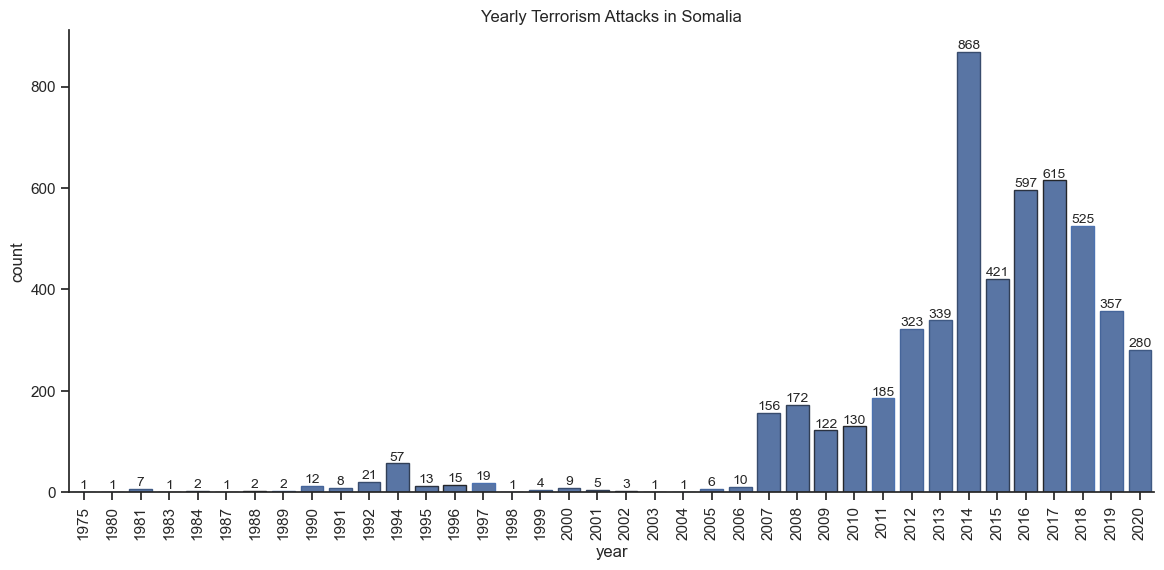

In [1228]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Count occurrences for each year
year_counts = df['year'].value_counts().sort_index()

# Create a figure for the countplot
plt.subplots(figsize=(14, 6))

# Create the countplot using the balanced color palette
ax = sns.countplot(data=df, x='year', edgecolor=sns.color_palette(palette, 7))

# Rotate x-ticks for better readability
plt.xticks(rotation=90)

# Set the title of the plot
plt.title('Yearly Terrorism Attacks in Somalia')

# Add the number of incidents on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Positioning the label
                ha='center', va='bottom', fontsize=10)

sns.despine()
# Show the plot
plt.show()

- ### **Which years experienced significant spikes or declines in attacks?**  

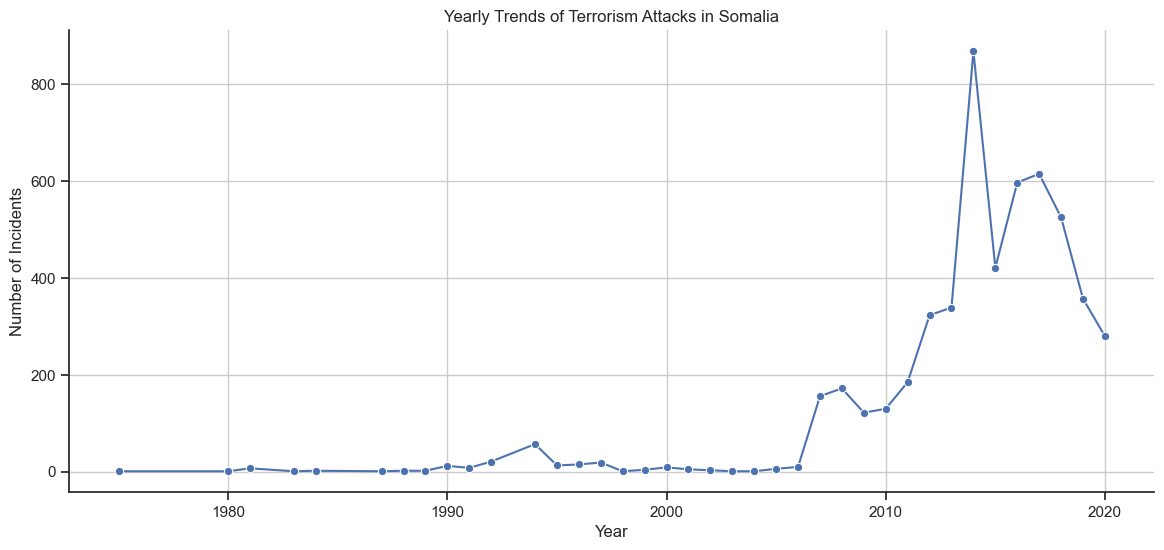

In [1229]:
# Group by year and count incidents
annual_counts = df.groupby('year').size()

# Set the Seaborn theme to 'ticks'
sns.set_theme(style='ticks')

# Create the line plot
plt.figure(figsize=(14, 6))
sns.lineplot(x=annual_counts.index, y=annual_counts.values, 
             marker="o", color=sns.color_palette("dark:b_r")[0])  # Use the first color from the palette

# Adding title and labels
plt.title("Yearly Trends of Terrorism Attacks in Somalia")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.grid(True)
sns.despine()
# Show the plot
plt.show()

- ### **Which months see the highest terrorism attacks?**  

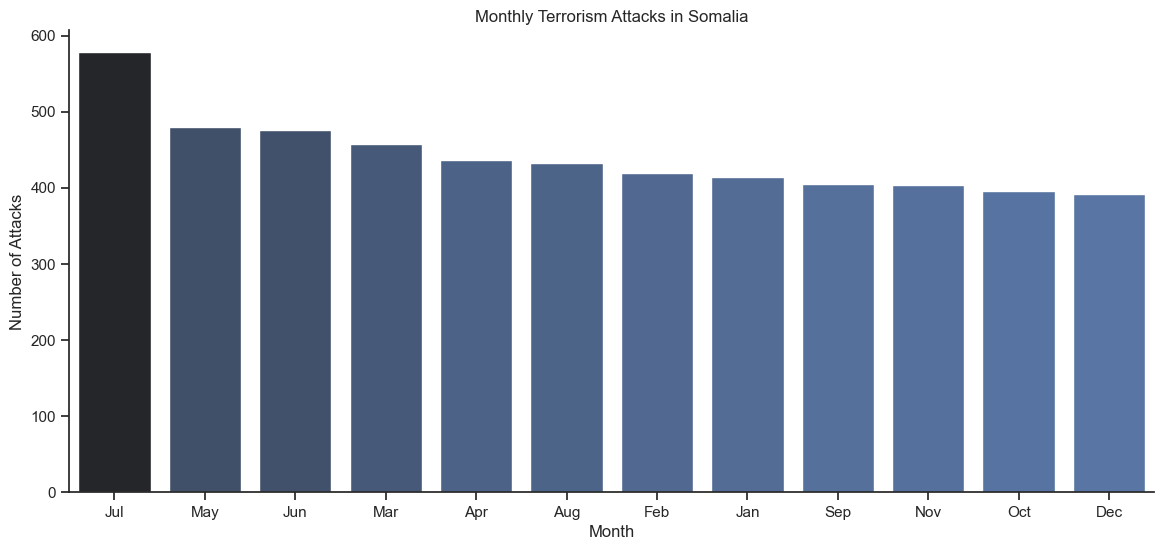

In [1230]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# 2. Attack count by month (Bar Chart)
attacks_per_month = df.groupby('month_name').size().reset_index(name='attack_count')
attacks_per_month = attacks_per_month.sort_values(by='attack_count', ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x='month_name', y='attack_count', hue='attack_count', legend=False, data=attacks_per_month, palette=palette)
plt.title('Monthly Terrorism Attacks in Somalia')
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
sns.despine()
plt.show()

- ### **Are certain days of the month associated with higher attack frequencies?**  

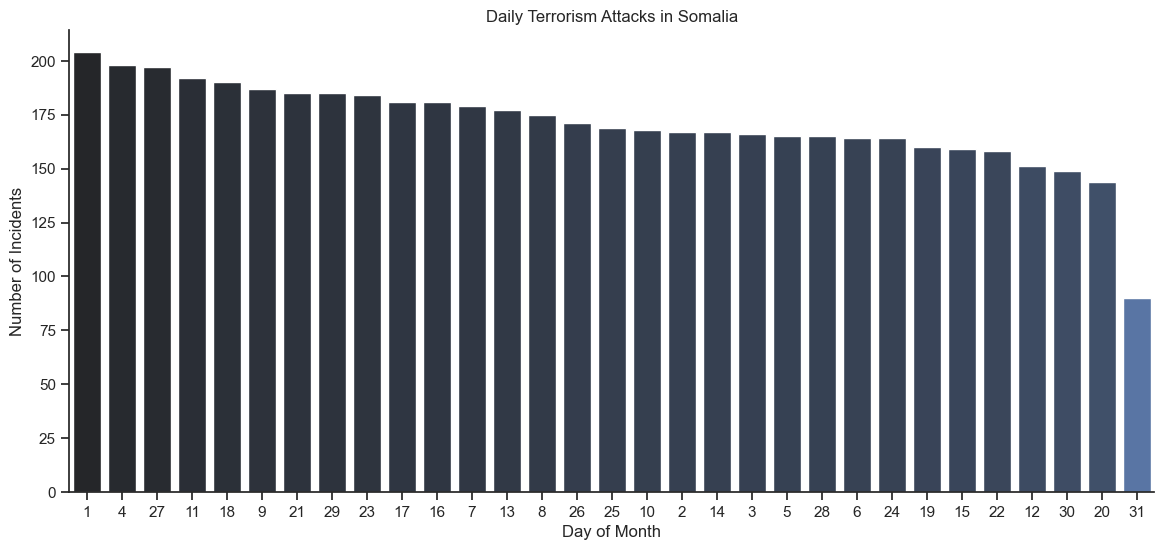

In [1231]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Create a new DataFrame with counts of incidents for each day
day_counts = df['day'].value_counts().reset_index()
day_counts.columns = ['day', 'incident_count']

# Sort the counts in descending order based on the incident count
day_counts = day_counts.sort_values(by='incident_count', ascending=False)

# Set the order of days based on the sorted values
day_order = day_counts['day']

# Plot: Days of the month showing higher attack frequencies
plt.figure(figsize=(14, 6))
sns.barplot(data=day_counts, x='day', y='incident_count', hue='incident_count', legend=False, palette=palette, order=day_order)
plt.title("Daily Terrorism Attacks in Somalia")
plt.xlabel("Day of Month")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=0)  # Rotate x-ticks if needed
sns.despine()
plt.show()

- ### **How do attacks vary by day of the week?**  

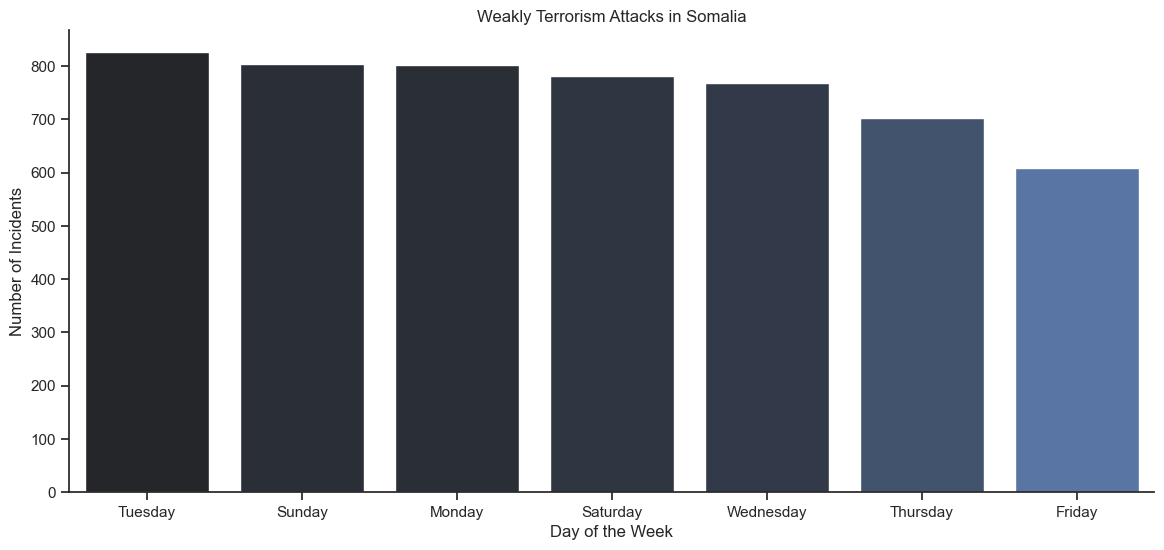

In [1232]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Create a new DataFrame with counts of incidents for each day of the week
day_of_week_counts = df['day_of_week'].value_counts().reset_index()
day_of_week_counts.columns = ['day_of_week', 'incident_count']

# Sort the counts in descending order based on the incident count
day_of_week_counts = day_of_week_counts.sort_values(by='incident_count', ascending=False)

# Set the order of days of the week based on the sorted values
day_order = day_of_week_counts['day_of_week']

# Plot: Days of the week showing higher attack frequencies
plt.figure(figsize=(14, 6))
sns.barplot(data=day_of_week_counts, x='day_of_week', y='incident_count', hue='incident_count', legend=False, palette=palette, order=day_order)
plt.title("Weakly Terrorism Attacks in Somalia")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=0)  # Rotate x-ticks if needed
sns.despine()
plt.show()

- ### **Do casualties increase over time?** 

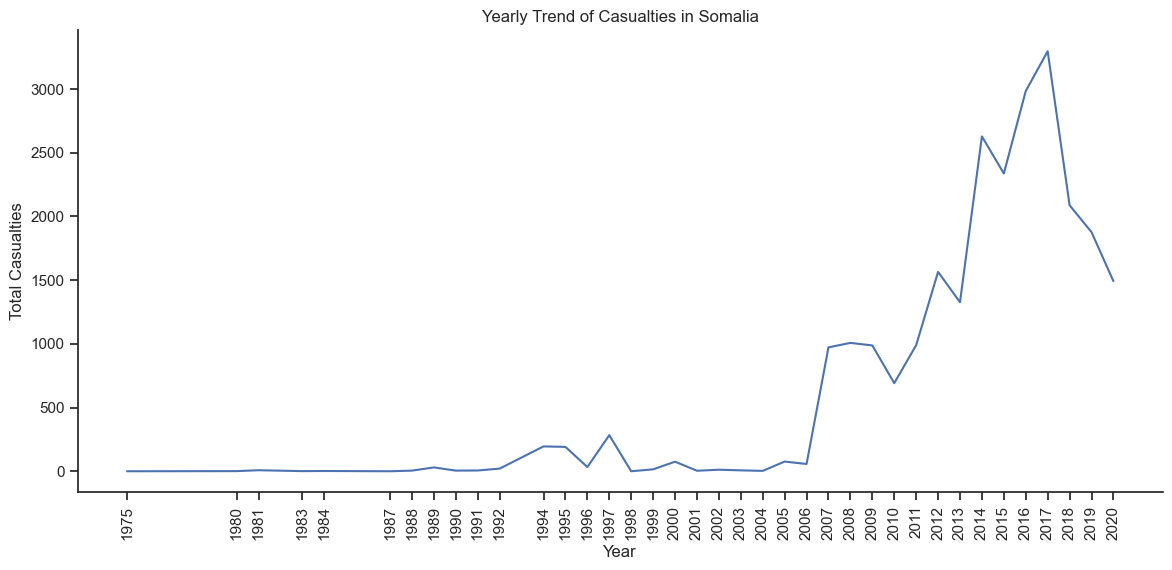

In [1233]:
# Group by year and sum casualties
annual_casualties = df.groupby('year')['total_casualties'].sum()

# Visualization
plt.figure(figsize=(14, 6))
sns.lineplot(x=annual_casualties.index, y=annual_casualties.values)
plt.title('Yearly Trend of Casualties in Somalia')
plt.xlabel('Year')
plt.ylabel('Total Casualties')
plt.xticks(annual_casualties.index)
plt.xticks(rotation=90)
sns.despine()
plt.show()

- #### **Are suicide attacks more frequent in certain months?**  

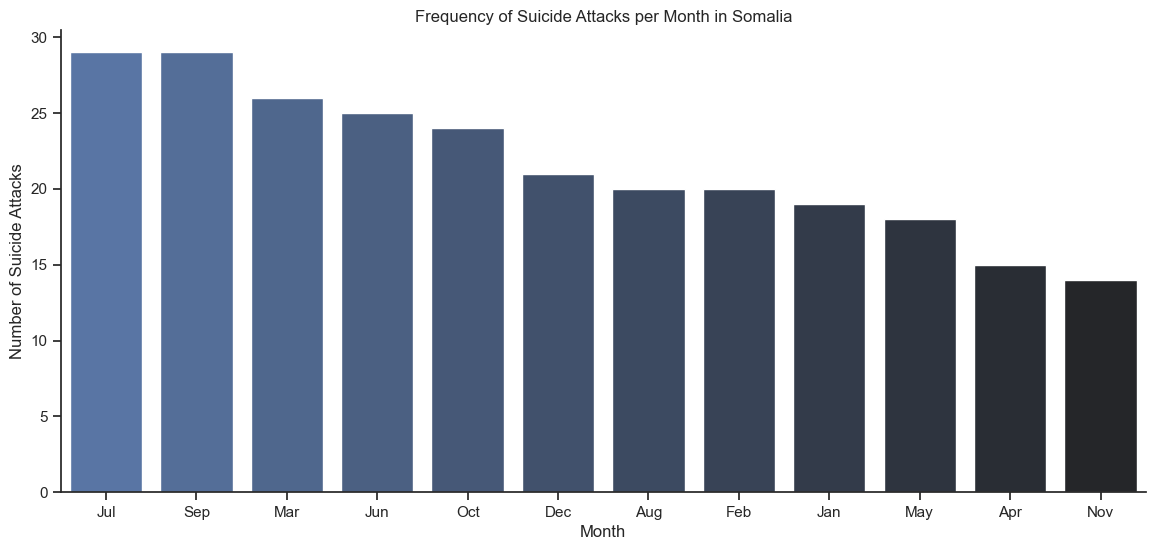

In [1234]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Count suicide attacks per month
monthly_suicide_attacks = df[df['suicide'] == 1]['month_name'].value_counts().sort_index()
monthly_suicide_attacks = monthly_suicide_attacks.sort_values(ascending=False)
# Visualization
plt.figure(figsize=(14, 6))
sns.barplot(x=monthly_suicide_attacks.index, y=monthly_suicide_attacks.values, palette=palette)
plt.title('Frequency of Suicide Attacks per Month in Somalia')
plt.xlabel('Month')
plt.ylabel('Number of Suicide Attacks')
plt.xticks(monthly_suicide_attacks.index)
sns.despine()
plt.show()

## **2. Geospatial Analysis**

- ### **Which Regions & Cities have the most Terrorism attacks?**  

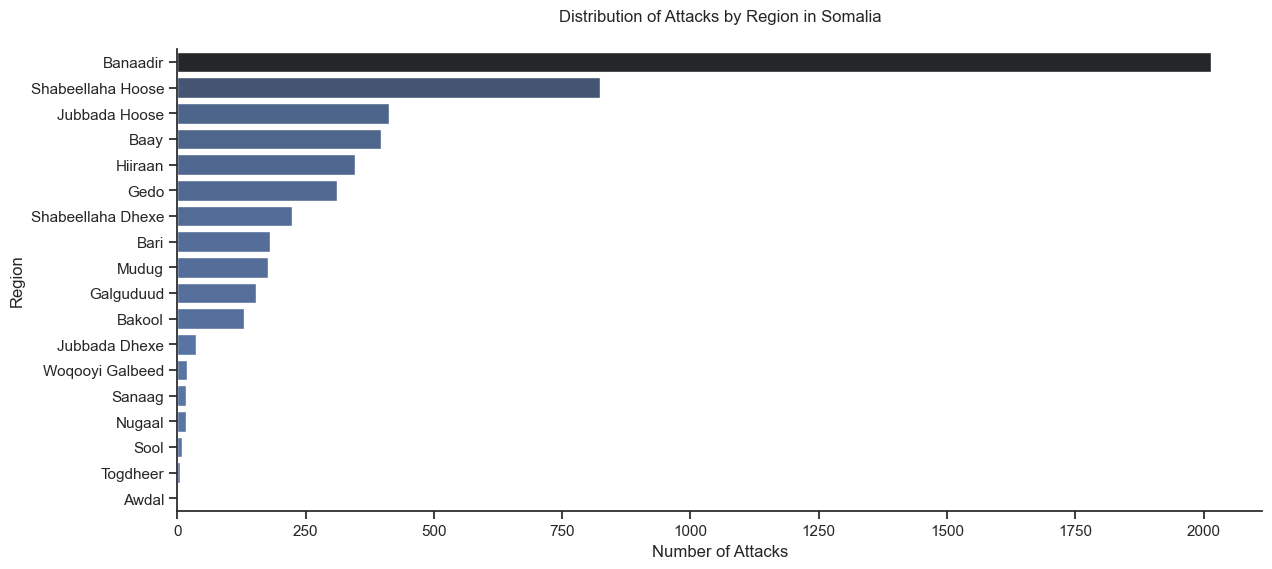

In [1235]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

df_reg = df[df['region']!= 'Unknown']
# Count attacks by region
region_attacks = df_reg['region'].value_counts().reset_index()
region_attacks.columns = ['region', 'attack_count']
region_attacks.sort_values(by='attack_count', ascending=False, inplace=True)

# Visualization
plt.figure(figsize=(14, 6))

# Create the bar plot for attack counts by region
sns.barplot(x='attack_count', y='region', hue='attack_count', legend=False, data=region_attacks, palette=palette)

# Set plot title and labels
plt.title('Distribution of Attacks by Region in Somalia', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('Region')
plt.xticks(rotation=0)
sns.despine()
# Show the plot
plt.show()

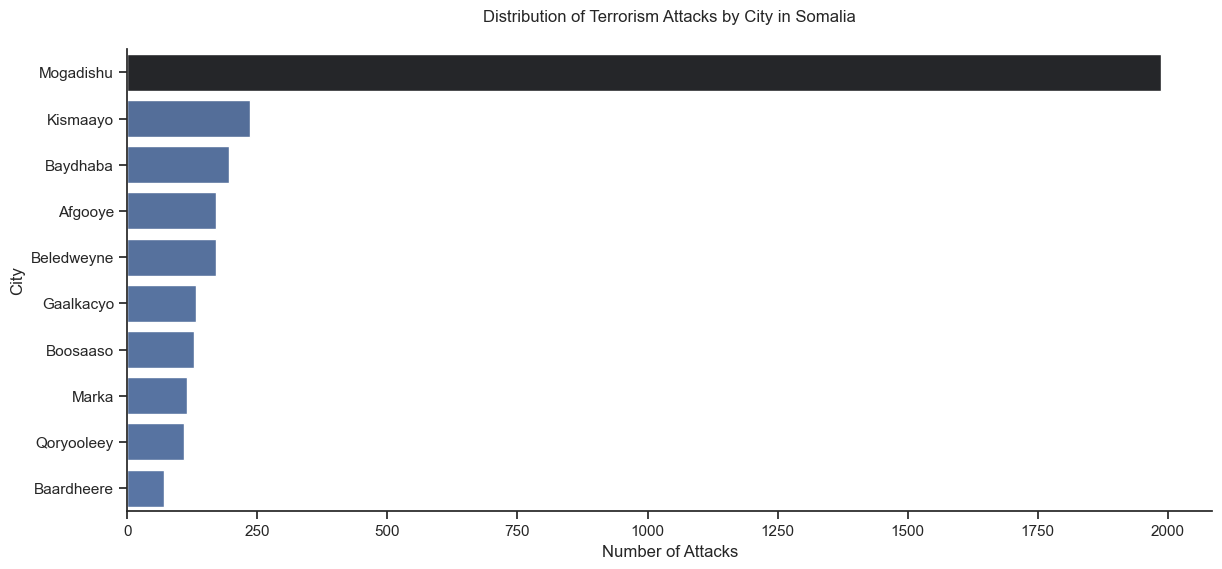

In [1236]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'
df_cit = df[df['city']!= 'Unknown']
# Count attacks by city
city_attacks = df_cit['city'].value_counts().reset_index()
city_attacks.columns = ['city', 'attack_count']
city_attacks.sort_values(by='attack_count', ascending=False, inplace=True)

# Filter for the top 20 cities
top_20_cities = city_attacks.head(10)

# Visualization
plt.figure(figsize=(14, 6))

# Create the bar plot for attack counts by top 15 cities
sns.barplot(x='attack_count', y='city', data=top_20_cities, hue='attack_count', legend=False,  palette=palette)

# Set plot title and labels
plt.title('Distribution of Terrorism Attacks by City in Somalia', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('City')
plt.xticks(rotation=0)
sns.despine()
# Show the plot
plt.show()


- ### **What cities are the primary hotspots for terrorist Attacks?**  

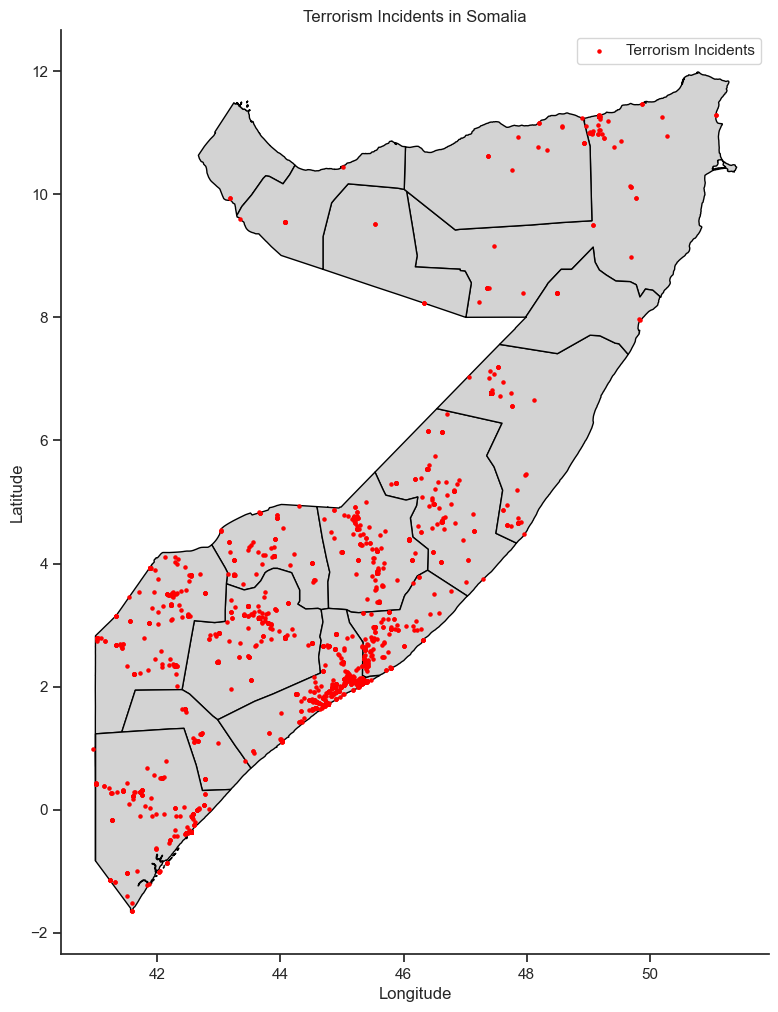

In [1237]:
# Assuming 'df' is your DataFrame with lat and long columns
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']))

# Load the GeoJSON file (replace 'your_geojson_file.geojson' with your actual file)
# You can also use a shapefile using gpd.read_file('path/to/shapefile.shp')
geojson_path = 'som.json'
geo_data = gpd.read_file(geojson_path)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 12))

# Plot the GeoJSON data
geo_data.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the points from your GeoDataFrame
gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Terrorism Incidents')

# Add labels and title
plt.title('Terrorism Incidents in Somalia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Save the static map
plt.savefig('somalia_terrorism_map_static.png', bbox_inches='tight')
sns.despine()
# Show the plot
plt.show()

- ### **What percentage of attacks occur in coastal, border, and other Cities?**  

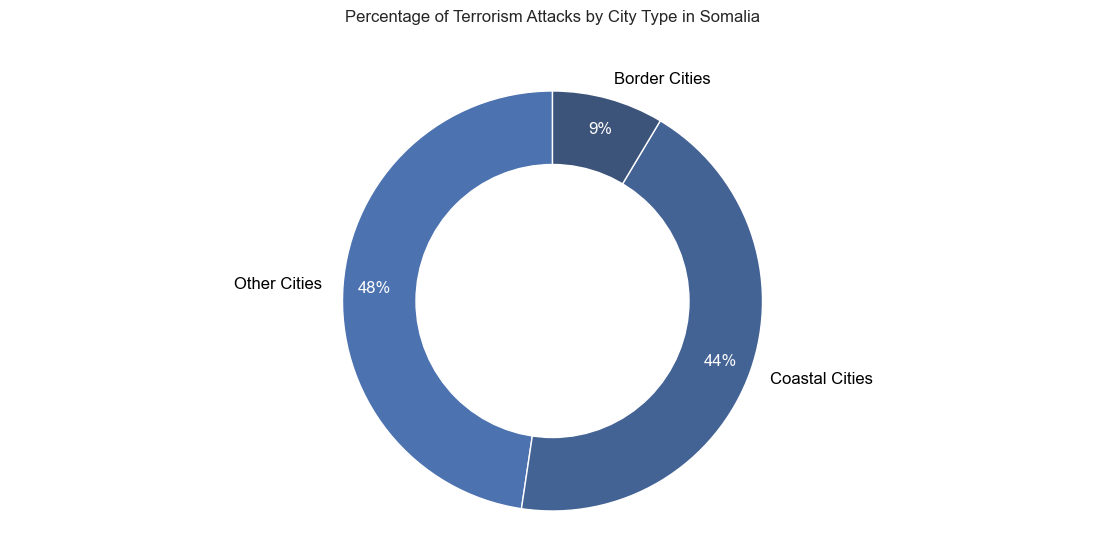

In [1297]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Define coastal and border cities
coastal_cities = ['Mogadishu', 'Kismayo',  'Hobyo', 'Qandala', 'Baraawe', 'Maydh', 'Baargaal', 
                  'Jamaame', 'Goobweyn', 'Jaziira', 'Gandarshe', 'Warsheikh', 'Cadale', 'Buurgaabo',
                  'Marka', 'Laas Qoray', 'Boosaaso', 'Eyl', 'Xarardheere', 'kambooni']

border_cities = ['Buulaxaawo', 'Baardheere', 'Ceel Waaq', 'Doolow', 'Luuq', 'Beledxaawo',
                 'Garbahaareey', 'Beledweyne', 'Dhoobleey', 'Caabud Waaq', 'Galdogob',
                 'Feer feer', 'Ceelbarde', 'Yeed', 'Diff', ''
                 ]

# Create a new column to classify city types
df['city_type'] = 'Other Cities'  # Default type
df.loc[df['city'].isin(coastal_cities), 'city_type'] = 'Coastal Cities'
df.loc[df['city'].isin(border_cities), 'city_type'] = 'Border Cities'

# Count the number of attacks by city type
city_counts = df['city_type'].value_counts(normalize=True).reset_index()
city_counts.columns = ['city_type', 'percentage']

# Visualization
plt.figure(figsize=(14, 6))

# Create the pie chart
wedges, texts, autotexts = plt.pie(city_counts['percentage'], labels=city_counts['city_type'],
                                  colors=palette, autopct=pct_color_white, startangle=90, pctdistance=0.85)

# Change the percentage font color to white and size
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

# Keep the label font black
for text in texts:
    text.set_color('black')
    text.set_fontsize(12)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Percentage of Terrorism Attacks by City Type in Somalia', pad=35)
sns.despine()
plt.show()

- ### **What are Percentage of Terrorism Attacks by Region**

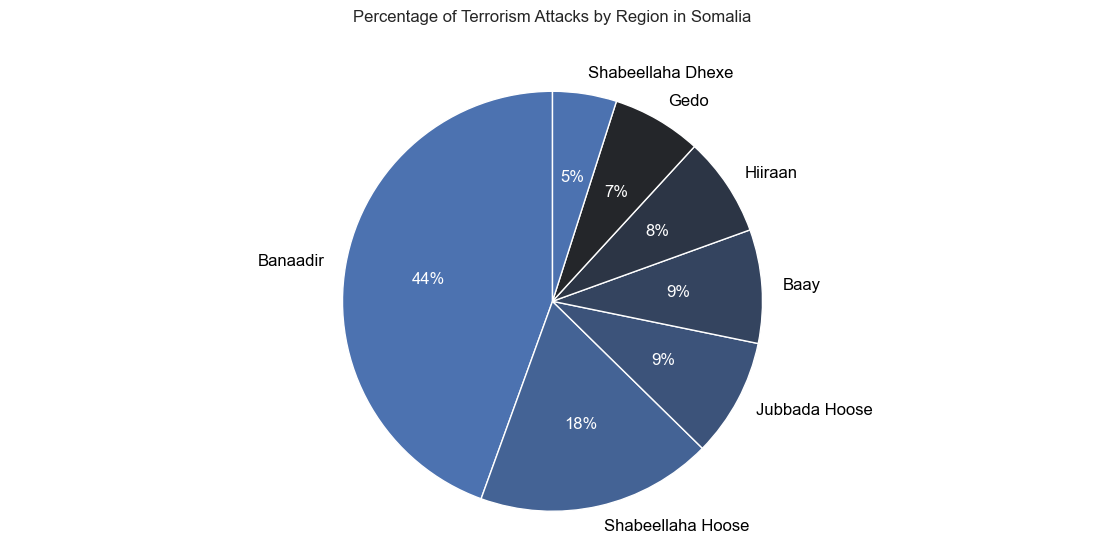

In [1240]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')  # Get the palette from Seaborn

# Assuming you have a column 'region' categorizing regions
region_distribution = df['region'].value_counts().head(7)

# Custom function to change the color of percentage labels
def pct_color_white(pct):
    return f'{pct:.0f}%' if pct > 0 else ''

# Visualization
plt.figure(figsize=(14, 6))

# Create a pie chart
wedges, texts, autotexts = plt.pie(region_distribution, labels=region_distribution.index,
                                   autopct=pct_color_white, startangle=90, colors=palette)

# Change the percentage font color to white and size
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

# Keep the label font black
for text in texts:
    text.set_color('black')
    text.set_fontsize(12)

plt.title('Percentage of Terrorism Attacks by Region in Somalia', pad=35)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


- ### **Are There Emerging Hotspots Over Time?**

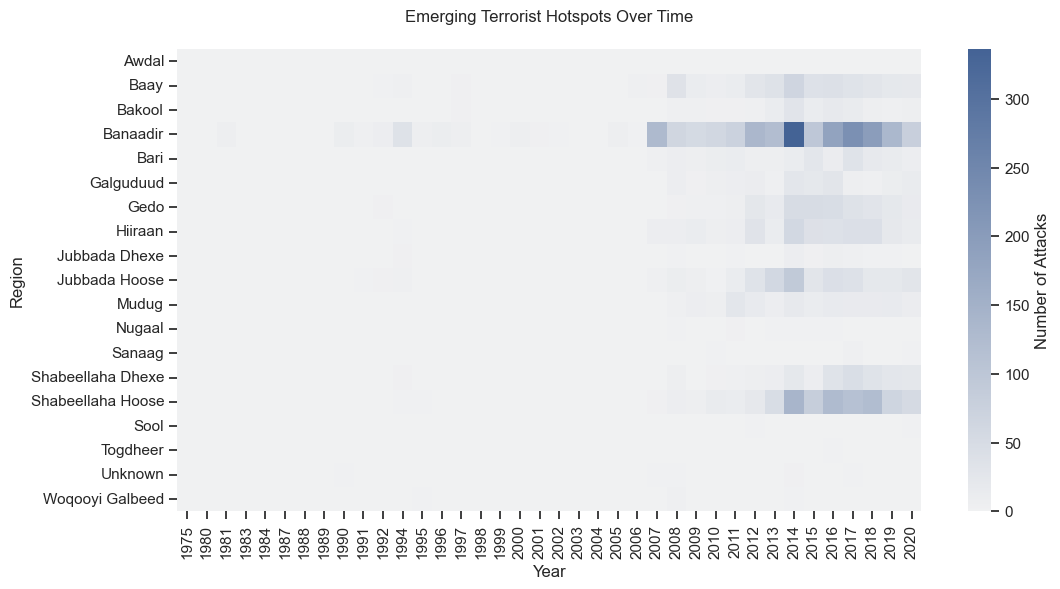

In [1241]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Create a pivot table for attack density over years
density_over_time = df.groupby(['region', 'year']).size().unstack(fill_value=0)

# Create a heatmap with the dark:b_r palette
plt.figure(figsize=(12, 6))

# Create a custom colormap using the specified palette
cmap = sns.light_palette(palette[1], as_cmap=True)

# Draw the heatmap
sns.heatmap(density_over_time, cmap=cmap, cbar_kws={'label': 'Number of Attacks'})
plt.title('Emerging Terrorist Hotspots Over Time', pad=20)
plt.xlabel('Year')
plt.ylabel('Region')
plt.show()

## **3. Attack Analysis**

- #### **What are the most common attack types in Somalia?**  

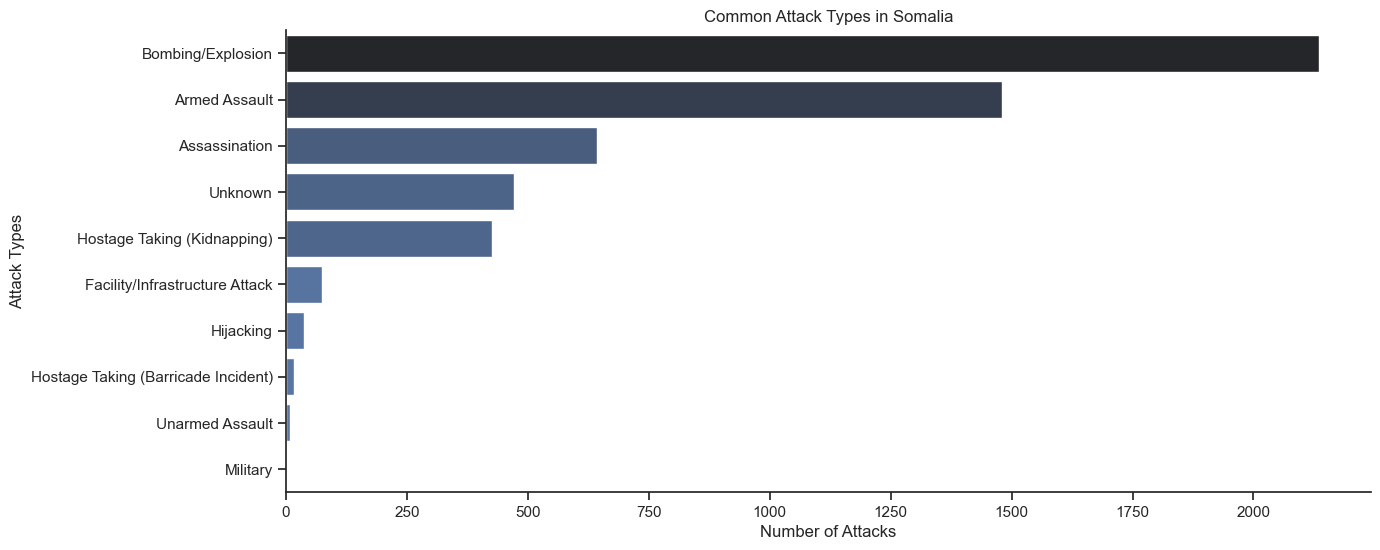

In [1242]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Count the number of attacks by state
attack_types = df['attack_type'].value_counts().reset_index()
attack_types.columns = ['attack_type', 'attack_count']

# Get the top 10 states and cities with the highest number of attacks
attack_types = attack_types.head(10)


# Plotting the top states
plt.figure(figsize=(14, 6))
sns.barplot(x='attack_count', y='attack_type', hue='attack_count', legend=False, data=attack_types, palette= palette)
plt.title('Common Attack Types in Somalia')
plt.xlabel('Number of Attacks')
plt.ylabel('Attack Types')
sns.despine()
plt.show()

- ### **What percentage of attacks use explosives?**  

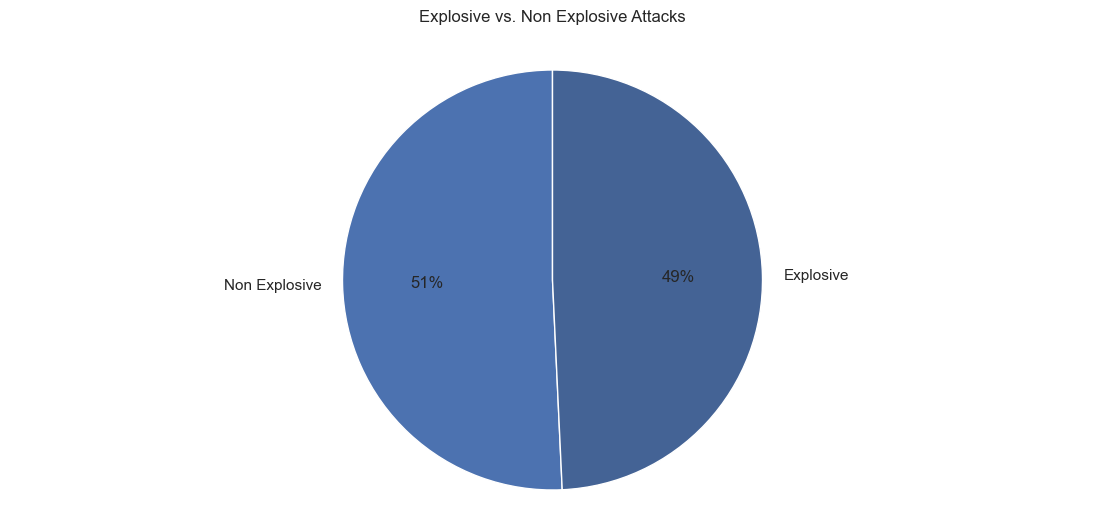

In [1282]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Count explosive vs. non-explosive attacks
explosive_attacks = df['weapon_type'].str.contains('Explosives', case=False)
explosive_counts = explosive_attacks.value_counts()

# Prepare data for the pie chart
labels = ['Non Explosive', 'Explosive']
sizes = explosive_counts.values

# Create the pie chart
plt.figure(figsize=(14, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90, colors=palette)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Explosive vs. Non Explosive Attacks', pad=20)
plt.show()

- ### **What attack types have the highest casualties?**  

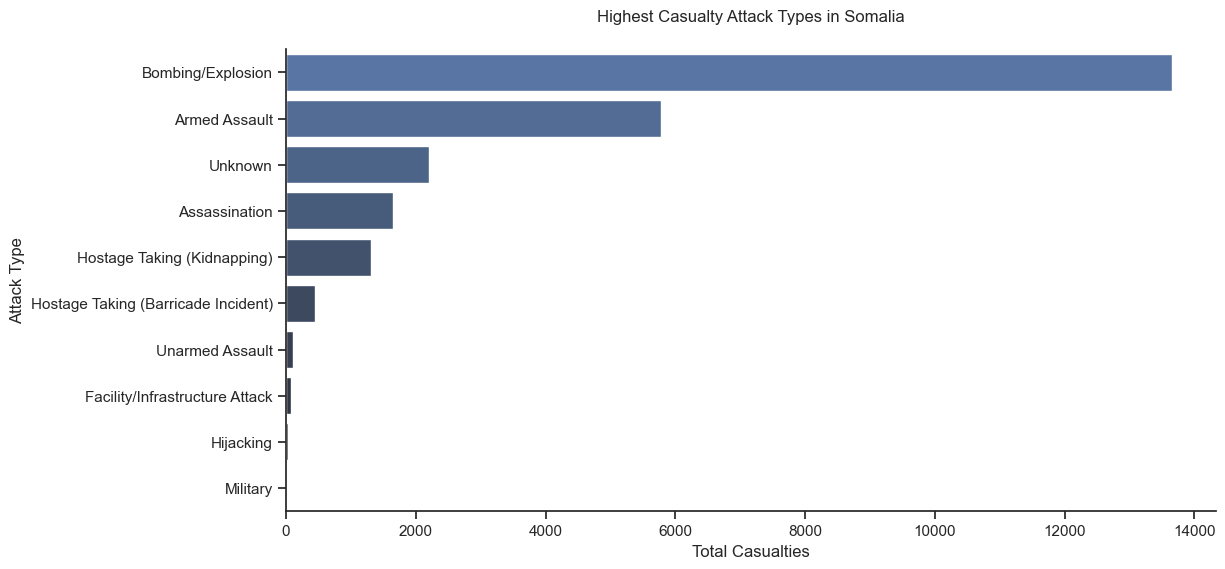

In [1244]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Calculate average casualties by attack type
avg_casualties_by_type = df.groupby('attack_type')['total_casualties'].sum().sort_values(ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_casualties_by_type.values, y=avg_casualties_by_type.index,  palette=palette)
plt.title('Highest Casualty Attack Types in Somalia', pad=20)
plt.xlabel('Total Casualties')
plt.ylabel('Attack Type')
plt.xticks(rotation=0)
sns.despine()
plt.show()


- ### **Are certain attack types more successful?**  

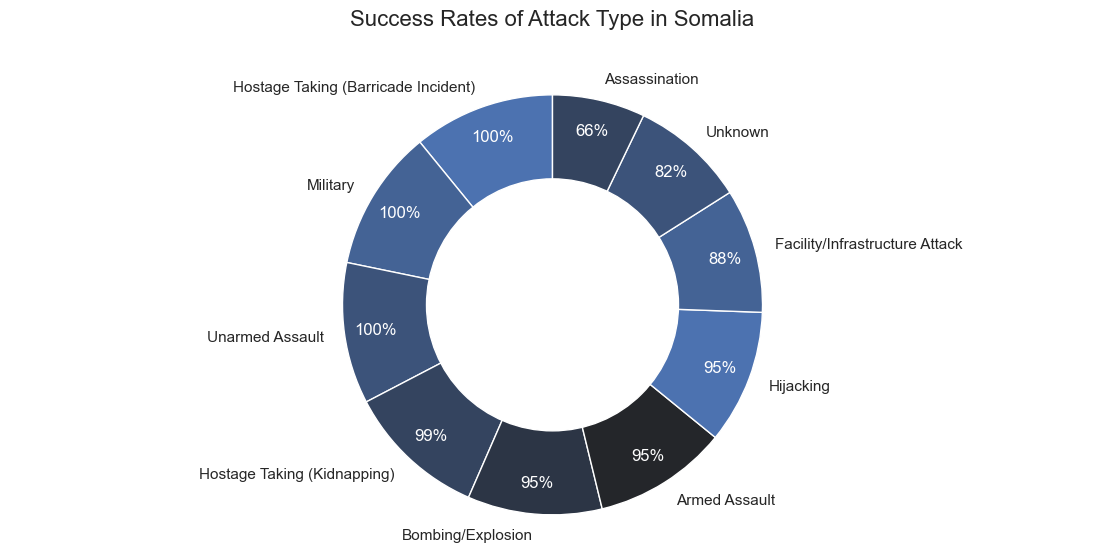

In [1245]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')  # Define the color palette

# Calculate success rates by attack type
success_rate_by_type = df.groupby('attack_type')['success'].mean().sort_values(ascending=False)

# Convert success rates to percentages
success_rate_percent = success_rate_by_type * 100

# Create a donut chart
plt.figure(figsize=(14, 6))
# Create a wedge plot with colors from the palette
wedges, texts, autotexts = plt.pie(success_rate_percent, 
                                   labels=success_rate_percent.index, 
                                   autopct='', startangle=90, pctdistance=0.85, 
                                   colors=palette)

# Draw a circle in the center to create a donut shape
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Draw the percentages on the donut chart with white font
for i, p in enumerate(autotexts):
    p.set_text(f'{success_rate_percent[i]:.0f}%')
    p.set_color('white')  # Set percentage text color to white
    p.set_fontsize(12)  # Adjust font size if needed

# Set title and adjust appearance
plt.title('Success Rates of Attack Type in Somalia', pad=35, fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular
plt.show()

- ### **How common are suicide attacks, and have they increased over time?**

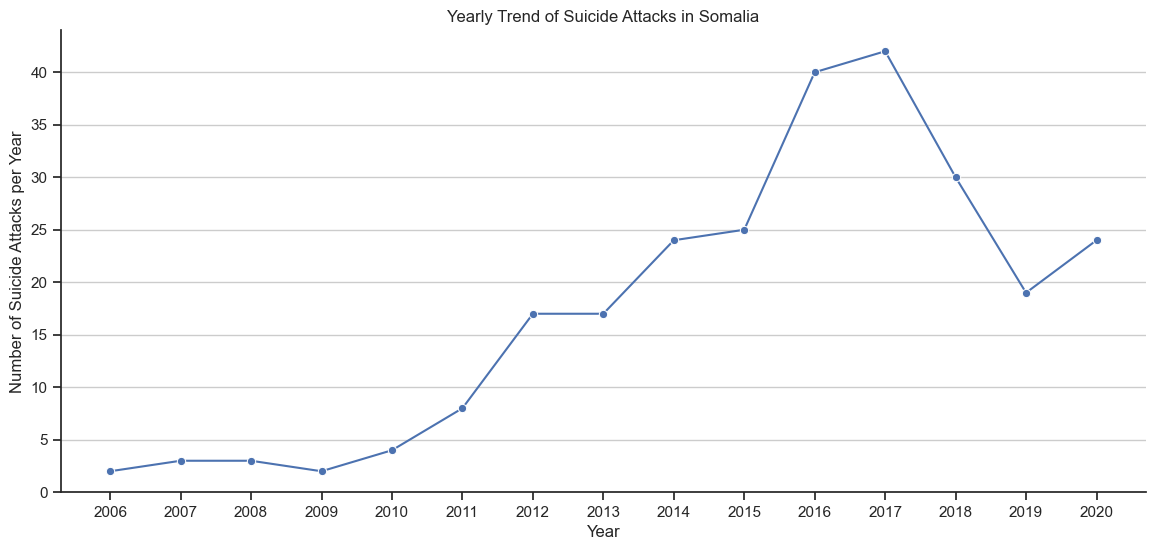

In [1246]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Count suicide attacks per year
suicide_attacks_per_year = df[df['suicide'] == 1].groupby('year')['eventid'].count()

# Visualization
plt.figure(figsize=(14, 6))
sns.lineplot(x=suicide_attacks_per_year.index, y=suicide_attacks_per_year.values, marker='o', palette=palette)
plt.title('Yearly Trend of Suicide Attacks in Somalia')
plt.xlabel('Year')
plt.ylabel('Number of Suicide Attacks per Year')
plt.xticks(suicide_attacks_per_year.index)
plt.grid(axis='y')
sns.despine()
plt.show()

- ### **Which weapon types are most common in suicide Attacks?**  

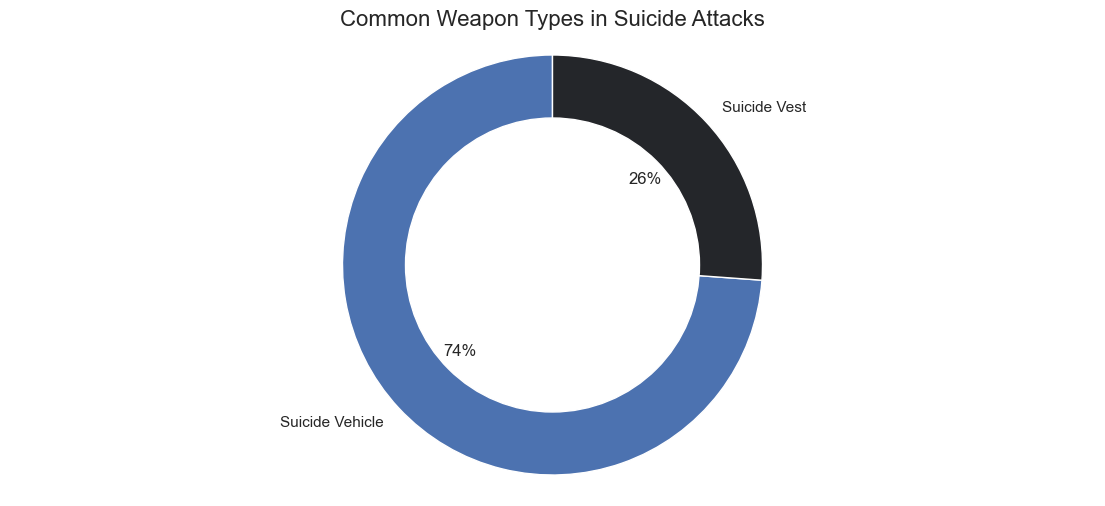

In [1247]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Filter for suicide attacks
suicide_attacks = df[df['suicide'] == 1]
# Count weapon types used in suicide attacks
weapon_counts = suicide_attacks['weapon_subtype'].value_counts()
# Calculate percentages
weapon_percentages = (weapon_counts / weapon_counts.sum()) * 100

# Visualization - Pie chart
plt.figure(figsize=(14, 6))
plt.pie(weapon_percentages, labels=weapon_percentages.index, autopct='%1.0f%%', startangle=90, colors=sns.color_palette(palette, len(weapon_percentages)))
# Draw a circle in the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set title and make the pie chart circular
plt.title('Common Weapon Types in Suicide Attacks', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

- ### **Is there a correlation between attack types and specific regions?** 

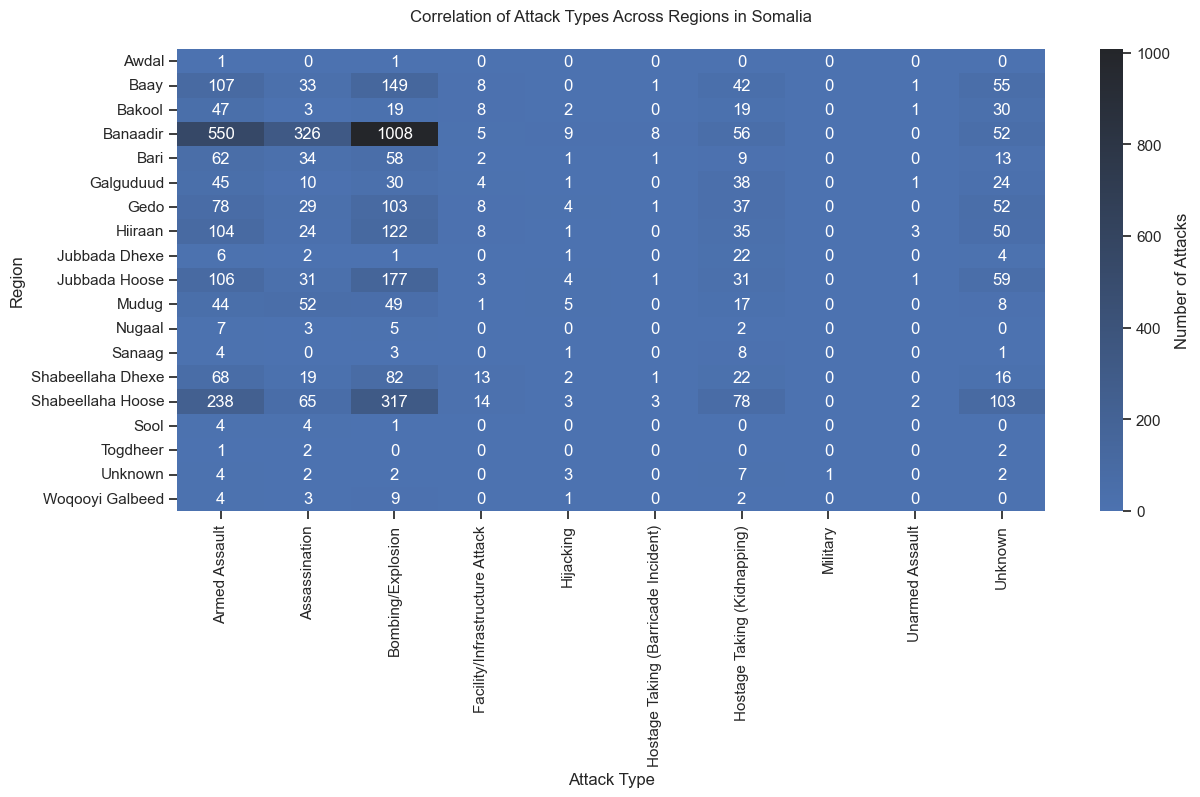

In [1248]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r', as_cmap=True)  # Create a color map

# Create a pivot table for attack type distribution across regions
attack_type_region = df.pivot_table(index='region', columns='attack_type', values='eventid', aggfunc='count', fill_value=0)

# Visualization
plt.figure(figsize=(14, 6))
sns.heatmap(attack_type_region, cmap=palette, annot=True, fmt='d', cbar_kws={'label': 'Number of Attacks'})
plt.title('Correlation of Attack Types Across Regions in Somalia', pad=20)
plt.xlabel('Attack Type')
plt.ylabel('Region')
plt.xticks(rotation=90)
plt.show()

## **4. Target Type**


- ### **What are the most frequently targeted groups in Somalia?**  

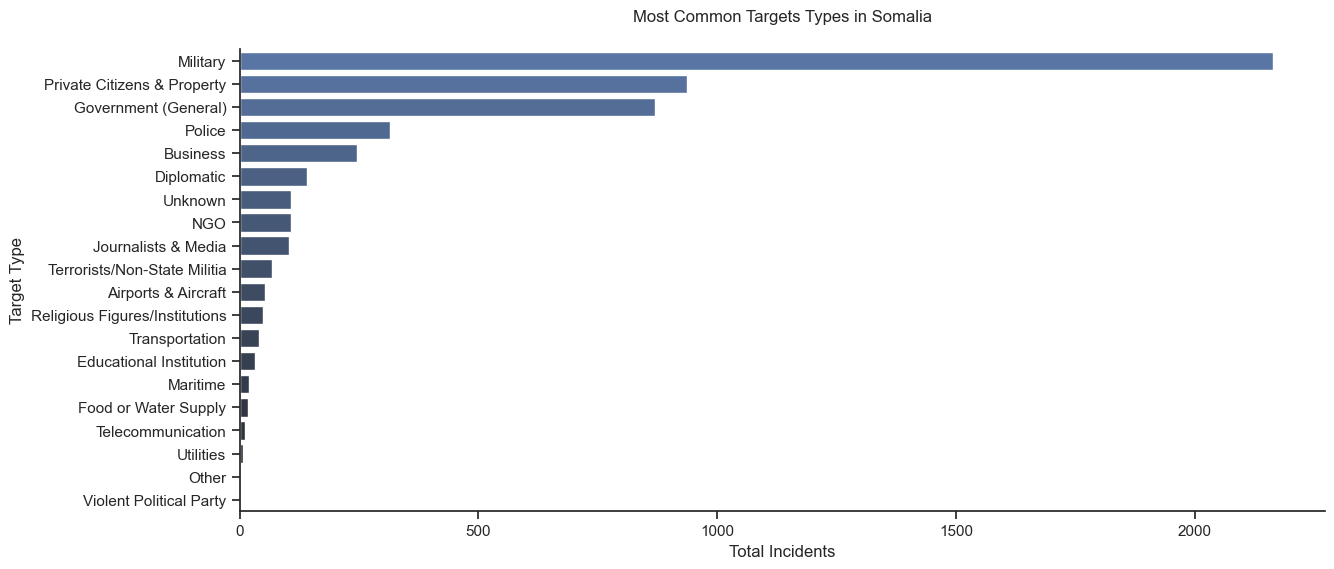

In [1249]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Target types
target_types = df['target_type'].value_counts().reset_index()
target_types.columns = ['target_type', 'count']

plt.figure(figsize=(14, 6))
sns.barplot(data=target_types, x='count', y='target_type', palette=palette)
plt.title('Most Common Targets Types in Somalia', pad=20)
plt.xlabel('Total Incidents')
plt.ylabel('Target Type')
sns.despine()
plt.show()

- ### **What percentage of attacks target civilians?**  

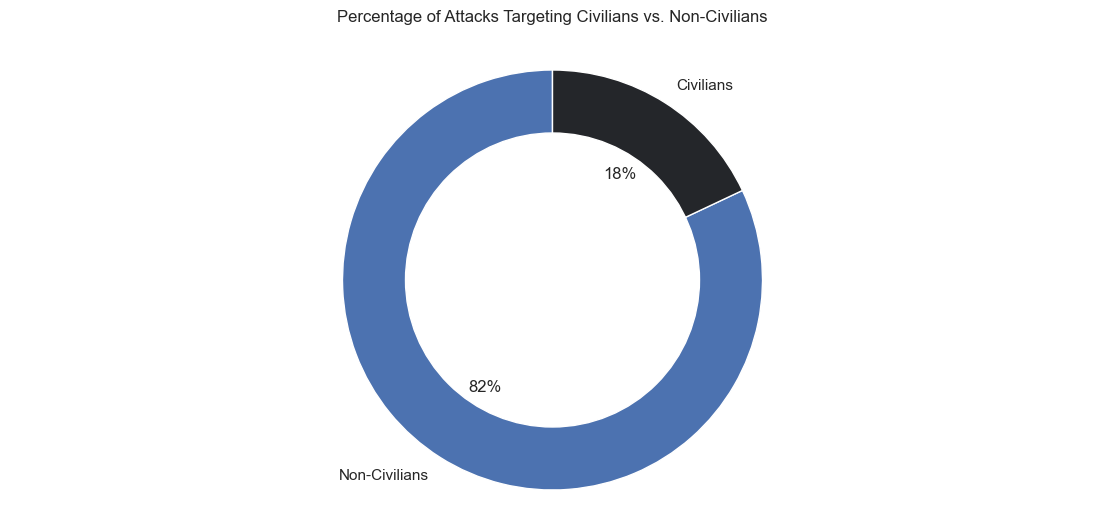

In [1250]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Refined list of keywords for civilian-related targets
civilian_keywords = [
    'Civilians', 'Traditional Elders', 'Clan Elders', 'Children', 'Women', 'Doctors', 'Journalists', 
    'Aid workers', 'Schools', 'Hospitals', 'Clinics', 'Teachers', 'Students', 'Refugees', 'University', 'Local NGO worker',
    'Local NGO worker' 'Markets', 'Shops', 'Mosques', 'Churches', 'Public Gatherings', 'Hotel', 'Residential area', 
    'Restaurant', 'Café', 'Coffee Shop', 'Tea Shop', 'Family Residence', 'Civilian Vehicle', 'Civilian Bus', 
    'Civilian Residence'
]

# Filter for civilian-related attacks
civilian_attacks = df['target'].str.contains(r'\b(?:' + '|'.join(civilian_keywords) + r')\b', case=False, na=False)

# Create a new column 'target_type' to categorize civilian vs. non-civilian attacks
df['target_type'] = 'Non-Civilians'  # Default category
df.loc[civilian_attacks, 'target_type'] = 'Civilians'  # Categorize civilians

# Calculate the percentage of attacks targeting civilians vs. non-civilians
target_counts = df['target_type'].value_counts(normalize=True) * 100

# Visualization - Pie chart
plt.figure(figsize=(14, 6))  # Adjust the figure size as needed
plt.pie(target_counts, labels=target_counts.index, autopct='%1.0f%%', startangle=90, 
        colors=sns.color_palette(palette, len(target_counts)))

# Add a center circle to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set title and equal aspect ratio
plt.title('Percentage of Attacks Targeting Civilians vs. Non-Civilians', pad=20)
plt.axis('equal')  # Ensures the pie chart is a circle
plt.show()


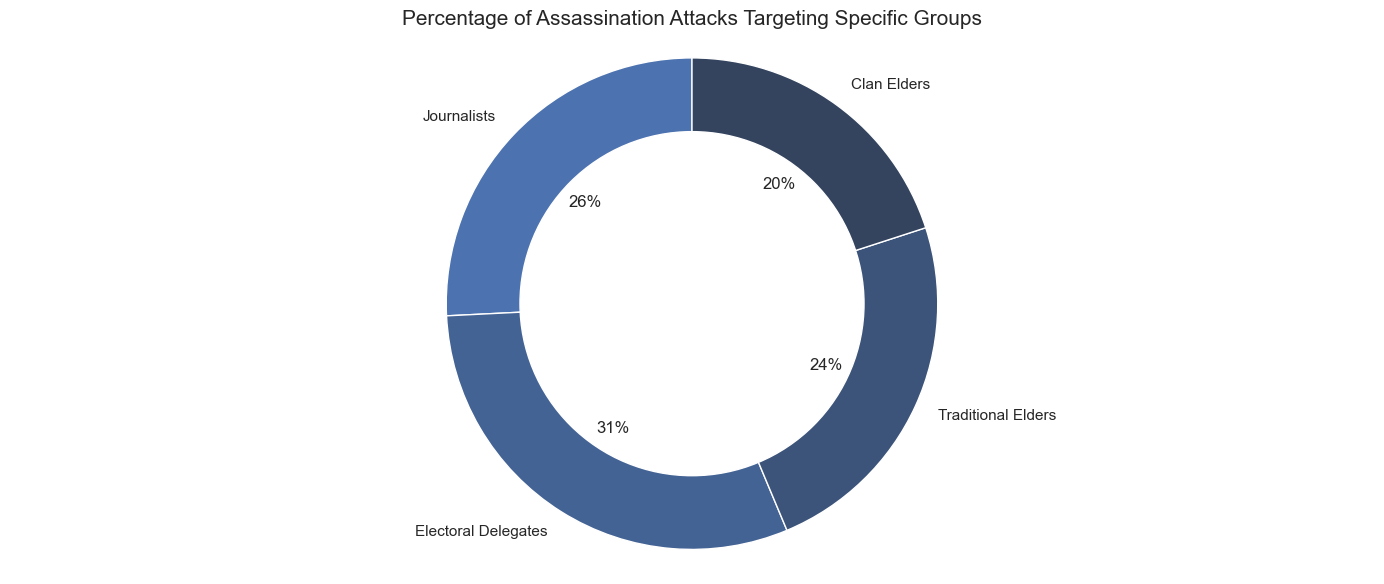

In [1251]:
# Set the Seaborn theme
sns.set_theme(style='ticks')

# Define the job titles you want to analyze
job_titles = [
    'Journalists',
    'Electoral Delegates',
    'Tribal Elders',
    'Traditional Elders',
    'Clan Elders'
]

# Expanded keywords for the specific job titles
keywords_mapping = {
    'Journalists': ['Journalist'],
    'Electoral Delegates': ['Electoral Delegates', 'Electoral Delegate', 
                            'Election Delegate', 'Polling Agent', 'Voting Delegate'],
    
    'Traditional Elders': ['Traditional Elders', 'Traditional Leader', 'Tribal Elder', 
                           'Community Leader', 'Tribal Leader', 'Chief'],
    'Clan Elders': ['Clan Elder', 'Family Elder', 'Elder', 'Patriarch', 'Matriarch']
}

# Prepare a list to hold the counts
attacks_counts = []

# Calculate counts for each job title
for job_title, keywords in keywords_mapping.items():
    # Create a regex pattern for filtering based on job titles
    pattern = '|'.join(keywords)
    
    # Filter the DataFrame for attacks targeting the job title and the "Assassination" attack type
    attacks_count = df[(df['target'].str.contains(pattern, case=False, na=False)) & 
                       (df['attack_type'] == 'Assassination')].shape[0]
    
    # Append the result to the list
    attacks_counts.append({'job_title': job_title, 'count': attacks_count})

# Convert the counts to a DataFrame
df_attacks_counts = pd.DataFrame(attacks_counts)

# Calculate the total number of attacks for percentage calculation
total_attacks = df.shape[0]

# Calculate percentages
df_attacks_counts['percentage'] = (df_attacks_counts['count'] / total_attacks) * 100

# Visualization - Pie chart
plt.figure(figsize=(14, 6))
plt.pie(df_attacks_counts['percentage'], labels=df_attacks_counts['job_title'], 
        autopct='%1.0f%%', startangle=90, colors=sns.color_palette('dark:b_r'))

# Draw a circle in the center to create a donut shape (optional)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set title
plt.title('Percentage of Assassination Attacks Targeting Specific Groups', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()  # Adjust the layout
plt.show()

- ### **Which target types see the most casualties?**  

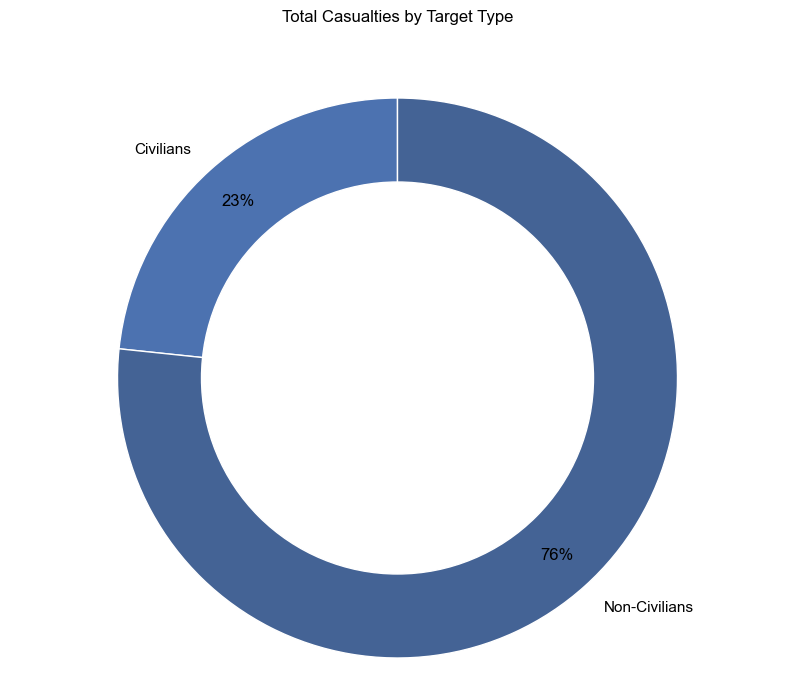

In [1295]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Group by target type and sum casualties
casualty_counts = df.groupby('target_type')['total_casualties'].sum().reset_index()

# Create a pie chart
plt.figure(figsize=(10, 8))

# Create the pie chart with white text for percentages
plt.pie(casualty_counts['total_casualties'], 
        labels=casualty_counts['target_type'], 
        autopct=lambda p: f'{int(p)}%', 
        startangle=90, 
        colors=palette, 
        textprops={'color': 'black'},  # Set percentage text color to white
        pctdistance=0.85)  # Distance of percentage text from the center

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title with black text
plt.title('Total Casualties by Target Type', pad=35, color='black')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [1296]:
import pandas as pd
import re

# Sample text containing summaries
text = """
01/20/1999: Five people were killed and six were injured when gunmen attacked a bus at the north Mogadishu Sana bus station in Somalia. Among those killed was a wealthy businessman, Mohamed Hassab Ali. The attackers were members of Matan Abdulle, an Abgaal sub-clan.
07/08/1999: Sheikh Abdullahi Irad of the Al-Ittihad al-Islamic (Islamic Unity) was shot by unidentified gunmen in Mogadishu, Somalia. It is believed that he was killed because of his efforts to promote the Islamic Brotherhood.
01/01/2000: Over six people were killed and ten were injured when their truck was attacked by a group of armed men. The victims were milk traders leaving Mogadishu. The attack was suspected to be clan-based revenge.
... (other summaries) ...
02/02/2007: An internally displaced refugee camp in Mogadishu, Somalia was attacked with mortars and four civilians were killed and ten were injured. The perpetrators of this incident were unknown. No claim of responsibility was reported.
"""

# Split the text into individual incidents
incidents = text.strip().split("\n")

# Initialize lists to store extracted data
data = []

# Define a regex pattern to extract information
pattern = re.compile(r"(?P<date>\d{2}/\d{2}/\d{4}): (?P<summary>.+?)(?=\.|$)")

# Loop through each incident and extract information
for incident in incidents:
    match = pattern.search(incident)
    if match:
        date = match.group("date")
        summary = match.group("summary")
        
        # Further extract details like casualties
        casualties = re.findall(r'(\d+)\s*(people|person|injured|killed)', summary)
        killed = sum(int(casualty[0]) for casualty in casualties if "killed" in casualty[1])
        injured = sum(int(casualty[0]) for casualty in casualties if "injured" in casualty[1])
        
        # Add extracted information to the list
        data.append({
            "date": date,
            "summary": summary,
            "killed": killed,
            "injured": injured,
            "location": re.search(r'in (.+?)(\.|$)', summary).group(1) if re.search(r'in (.+?)(\.|$)', summary) else None
        })

# Create a DataFrame from the extracted data
df_incidents = pd.DataFrame(data)

# Display the DataFrame
print(df_incidents)


         date                                            summary  killed  \
0  01/20/1999  Five people were killed and six were injured w...       0   
1  07/08/1999  Sheikh Abdullahi Irad of the Al-Ittihad al-Isl...       0   
2  01/01/2000  Over six people were killed and ten were injur...       0   
3  02/02/2007  An internally displaced refugee camp in Mogadi...       0   

   injured                                           location  
0        0                                            Somalia  
1        0                                 Mogadishu, Somalia  
2        0                                               None  
3        0  Mogadishu, Somalia was attacked with mortars a...  


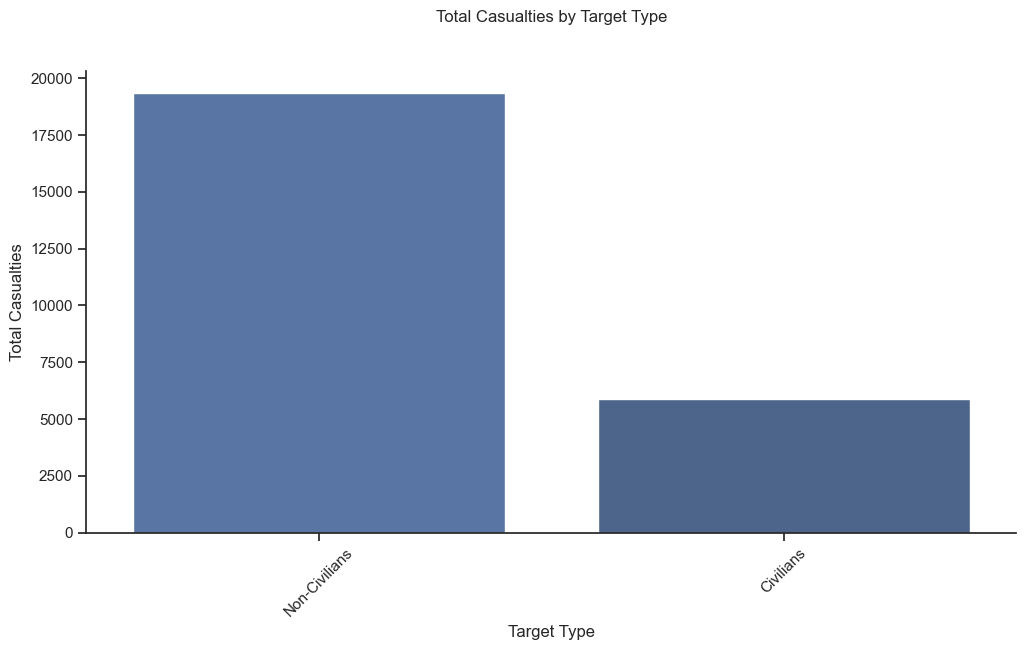

In [1291]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Group by target type and sum casualties
casualty = df.groupby('target_type')['total_casualties'].sum().reset_index()

# Sort the results by casualties in descending order
casualty = casualty.sort_values(by='total_casualties', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=casualty, x='target_type', y='total_casualties', palette=palette)

plt.title('Total Casualties by Target Type', pad=35)
plt.xlabel('Target Type')
plt.ylabel('Total Casualties')
plt.xticks(rotation=45)  # Rotate x labels for better readability
sns.despine()
plt.show()

- ### **What are the most frequently targets?**  

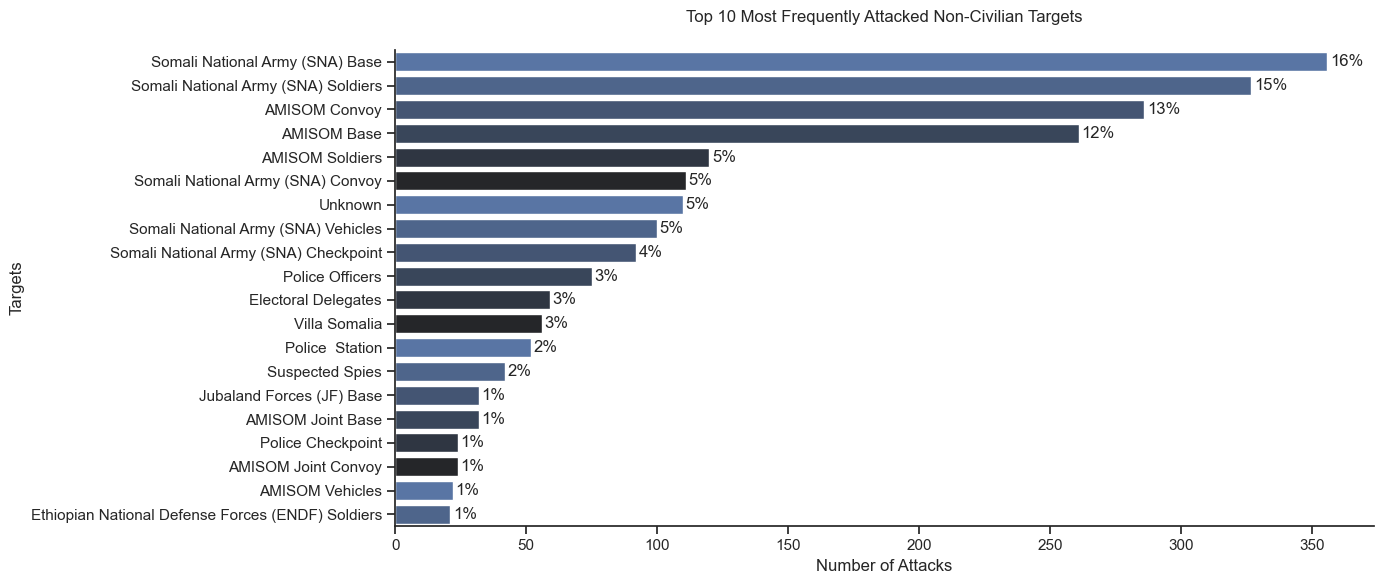

In [1252]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Calculate the count of each unique target, excluding civilian-related keywords
non_civilian_targets = df[~df['target'].str.contains(r'\b(?:' + '|'.join(civilian_keywords) + r')\b', case=False, na=False)]
specific_target_counts = non_civilian_targets['target'].value_counts().head(20)

# Calculate the percentage of each target
total_attacks = specific_target_counts.sum()
percentages = (specific_target_counts / total_attacks) * 100

# Visualization - Bar chart of the top 10 non-civilian targets with percentages
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=specific_target_counts.values, y=specific_target_counts.index, palette=palette)

# Annotate bars with percentage labels
for i, (count, percentage) in enumerate(zip(specific_target_counts, percentages)):
    ax.text(count + 1, i, f'{percentage:.0f}%', va='center')

# Add titles and labels
plt.title('Top 10 Most Frequently Attacked Non-Civilian Targets', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('Targets')
plt.xticks(rotation=0)
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()


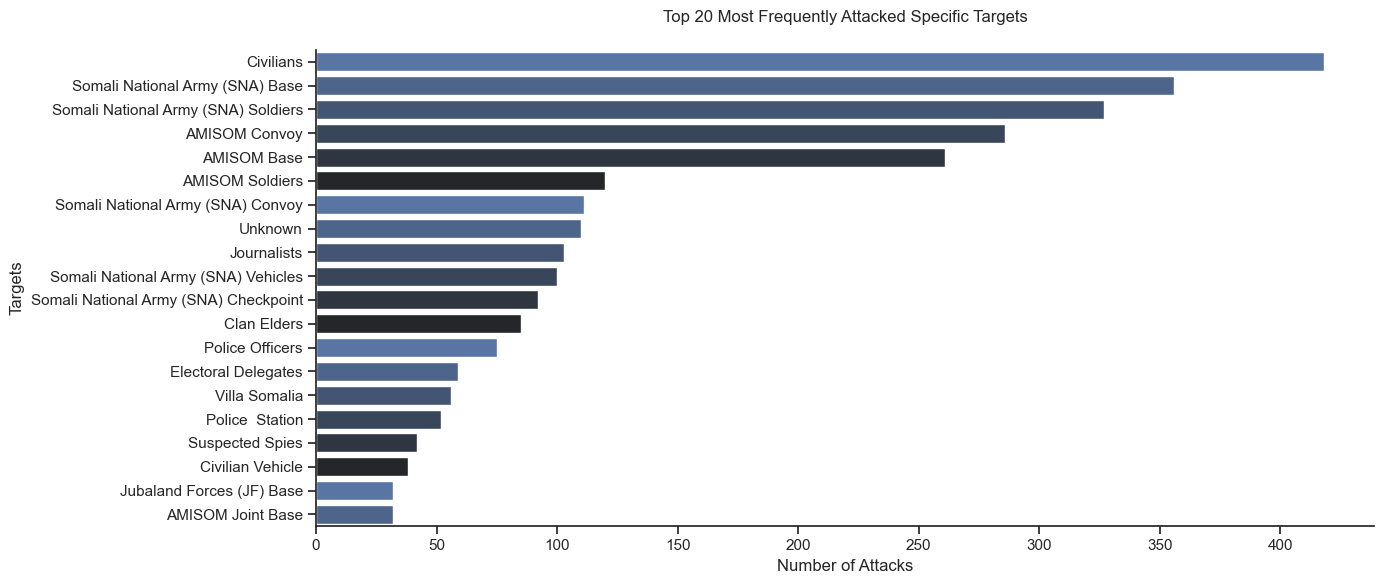

In [1253]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Count specific targets and sort by the number of attacks (descending order)
specific_target_counts = df['target'].value_counts().head(20)

# Select the top 20 targets
top_20_targets = specific_target_counts

# Visualization - Bar chart of the top 20 specific targets
plt.figure(figsize=(14, 6))
sns.barplot(x=top_20_targets.values, y=top_20_targets.index, palette=palette)
plt.title('Top 20 Most Frequently Attacked Specific Targets', pad=20)
plt.xlabel('Number of Attacks')
plt.ylabel('Targets')
plt.xticks(rotation=0)
plt.tight_layout()
sns.despine()
# Show the plot
plt.show()

## **5. Perpetrator Analysis**

- ### **Which terrorist groups are most active in Somalia?** 

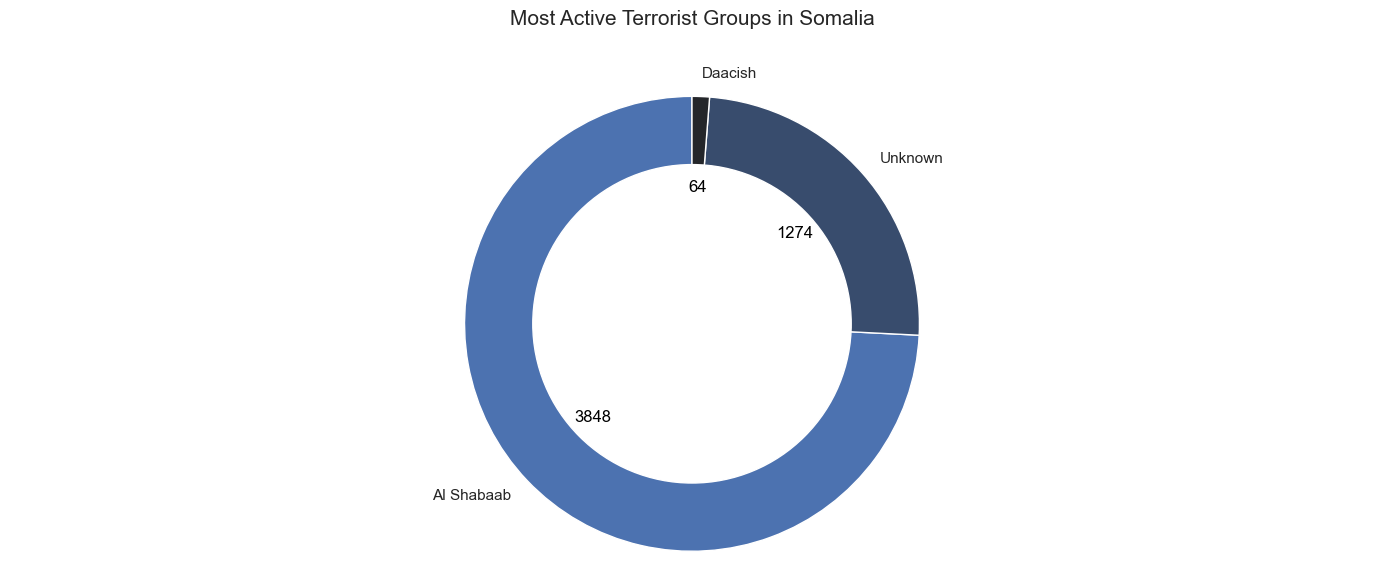

In [1254]:
# Set the Seaborn theme
sns.set_theme(style='ticks')

# Count attacks by perpetrator groups
group_counts = df['group_name'].value_counts()

# Select the top 3 groups
top_groups = group_counts.head(3)

# Visualization - Donut chart
plt.figure(figsize=(14, 6))

# Create a wedge plot
wedges, texts, autotexts = plt.pie(top_groups.values, labels=top_groups.index, 
                                   autopct='', startangle=90, colors=sns.color_palette('dark:b_r', len(top_groups)))

# Draw a circle in the center to create a donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Draw the percentages on the donut chart
for i, p in enumerate(autotexts):
    p.set_text(f'{top_groups.values[i]}')
    p.set_color('black')  # Set text color for better readability

# Set title and equal aspect ratio
plt.title('Most Active Terrorist Groups in Somalia', pad=35, fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()

- ### **How has the influence of groups like Al-Shabaab evolved?**  

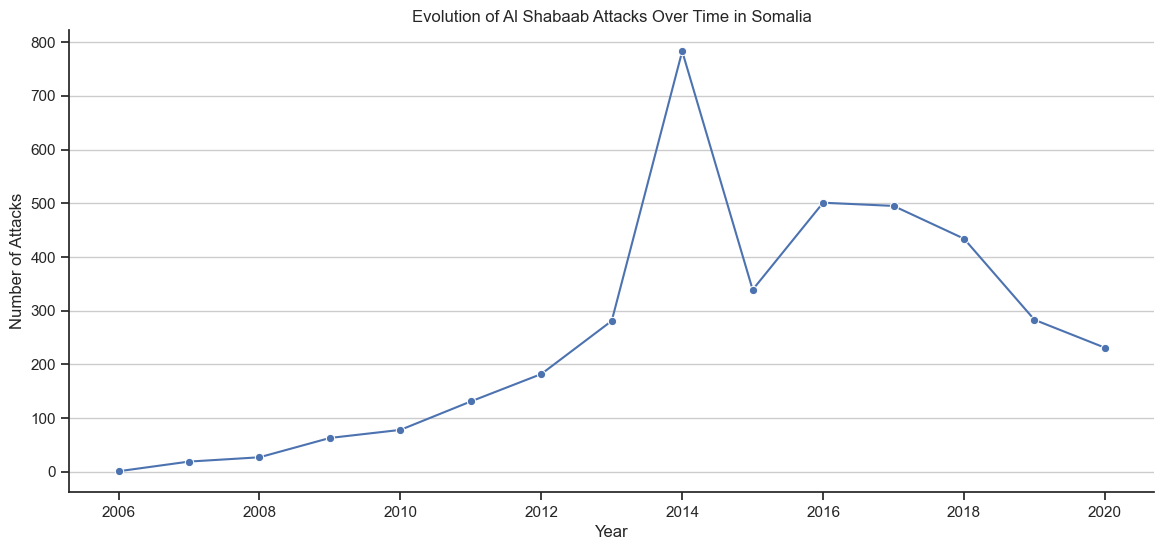

In [1255]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Filter attacks by Al-Shabaab
al_shabaab_attacks = df[df['group_name'] == 'Al Shabaab']

# Count attacks by year
al_shabaab_by_year = al_shabaab_attacks['year'].value_counts().sort_index()

# Visualization - Line graph
plt.figure(figsize=(14, 6))
sns.lineplot(x=al_shabaab_by_year.index, y=al_shabaab_by_year.values, marker='o', palette=palette)
plt.title('Evolution of Al Shabaab Attacks Over Time in Somalia')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=0)
plt.grid(axis='y')  # Set to 'y' for horizontal grid lines only
sns.despine()
plt.show()

- ### **What are the most common attack types used by the top Terrorist Groups in Somalia?**

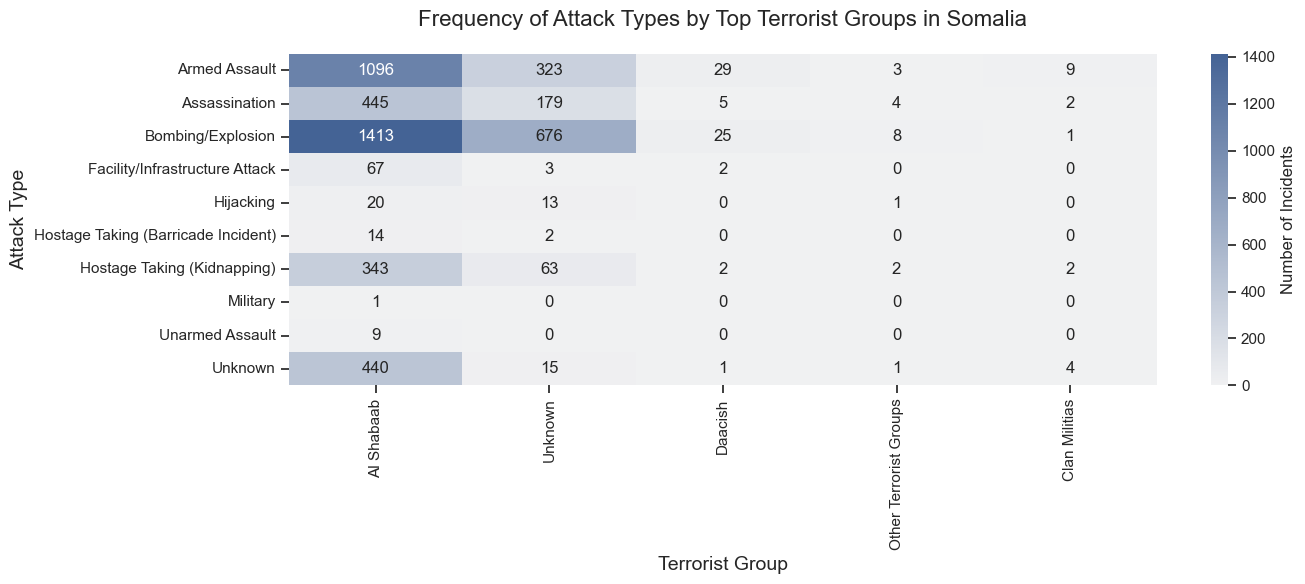

In [1256]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')

# Group by terrorist group and attack type, then count the number of incidents
attack_type_group = df.groupby(['group_name', 'attack_type']).size().unstack(fill_value=0)

# Calculate the total number of incidents per terrorist group and get the top five
top_five_groups = attack_type_group.sum(axis=1).nlargest(5).index
attack_type_group_top_five = attack_type_group.loc[top_five_groups]

# Create a custom colormap using the specified palette
cmap = sns.light_palette(palette[1], as_cmap=True)

# Plotting the heatmap with axes swapped
plt.figure(figsize=(14, 6))
sns.heatmap(attack_type_group_top_five.T, annot=True, fmt='d', cmap=cmap, cbar_kws={'label': 'Number of Incidents'})

# Customize the plot
plt.title('Frequency of Attack Types by Top Terrorist Groups in Somalia', pad=20, fontsize=16)
plt.xlabel('Terrorist Group', fontsize=14)
plt.ylabel('Attack Type', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# Show the plot
plt.show()

### **6. Weapon Effectiveness**

- ### **What are the most commonly used weapons in terrorism attacks?**  

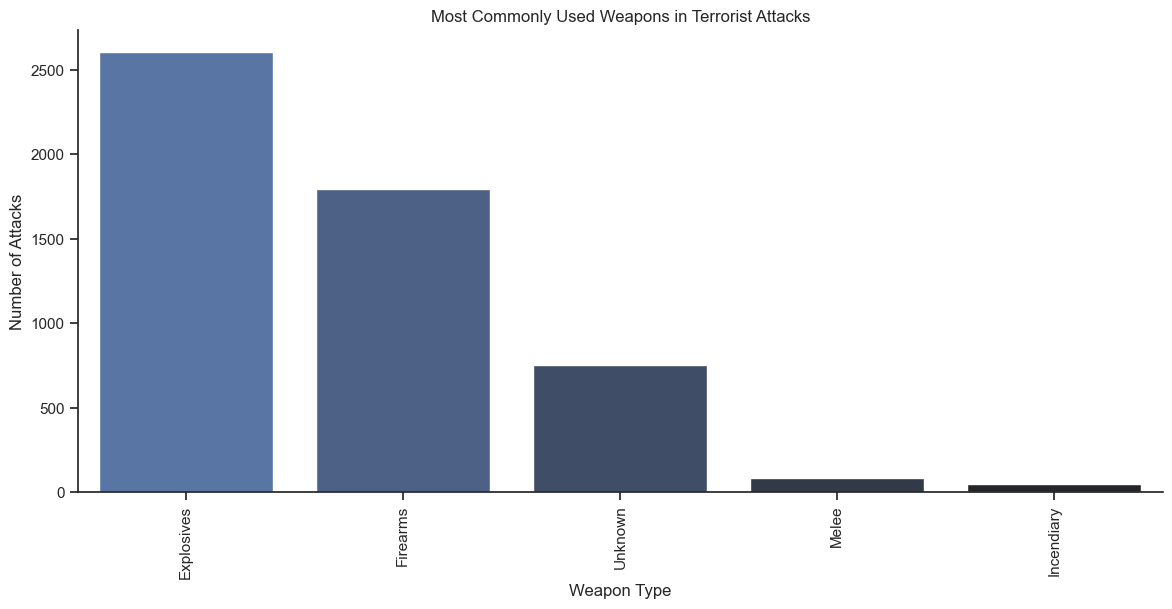

In [1257]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Count the number of attacks by weapon type
weapon_counts = df['weapon_type'].value_counts()

# Visualization - Bar chart
plt.figure(figsize=(14, 6))
sns.barplot(x=weapon_counts.index[:5], y=weapon_counts.values[:5], palette=palette)
plt.title('Most Commonly Used Weapons in Terrorist Attacks')
plt.xlabel('Weapon Type')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=90)
sns.despine()
plt.show()



- ### **What percentage of attacks use Explosives vs. Firearms?**  

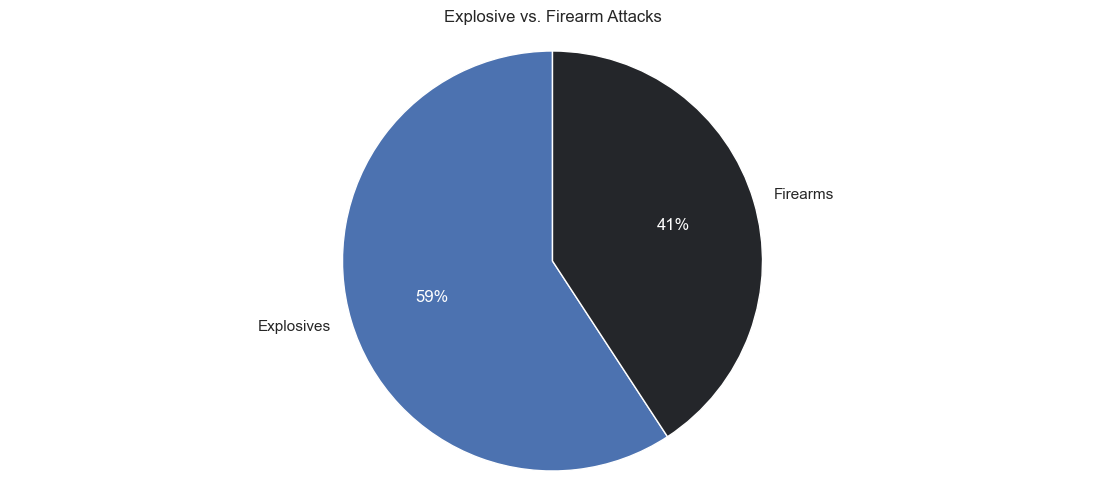

In [1258]:
# Set the Seaborn theme
sns.set_theme(style='ticks')

# Filter for explosives and firearms
explosives_firearms = df['weapon_type'].isin(['Explosives', 'Firearms'])

# Count occurrences of each weapon type (Explosives vs Firearms)
weapon_comparison = df[explosives_firearms]['weapon_type'].value_counts()

# Visualization - Pie chart
plt.figure(figsize=(14, 6))
wedges, texts, autotexts = plt.pie(
    weapon_comparison, 
    labels=weapon_comparison.index, 
    autopct='',  # Temporarily disable automatic percentage display
    startangle=90, 
    colors=sns.color_palette(palette, len(weapon_comparison))
)

# Draw the percentages on the pie chart
for i, p in enumerate(autotexts):
    p.set_text(f'{weapon_comparison.values[i] / weapon_comparison.sum() * 100:.0f}%')  # Set text to show percentage
    p.set_color('white')  # Set text color to white

plt.title('Explosive vs. Firearm Attacks')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


- ### **Which weapons cause the most Casualties?**  

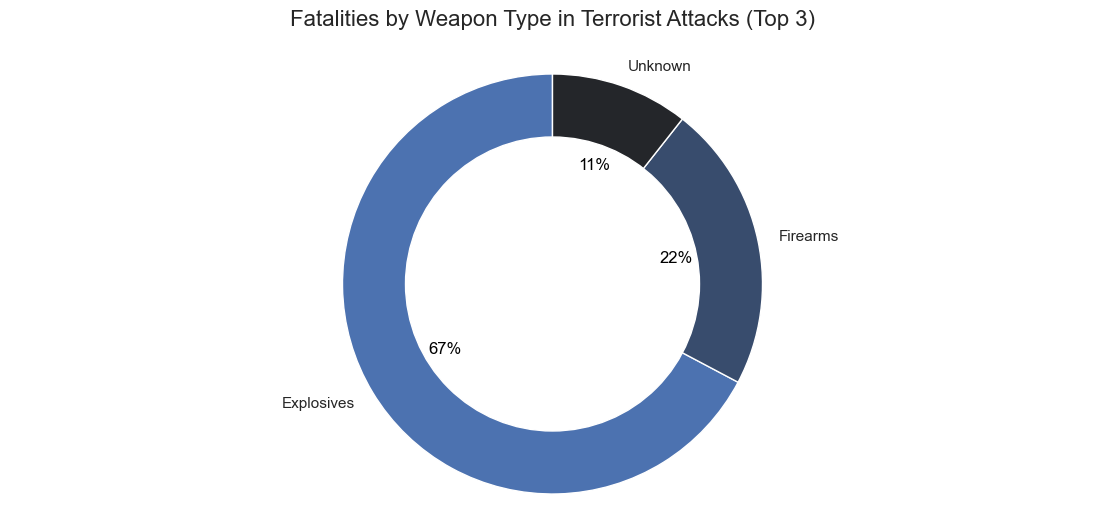

In [1259]:
# Set the Seaborn theme
sns.set_theme(style='ticks')

# Group by weapon type and calculate total fatalities
fatalities_by_weapon = df.groupby('weapon_type')['total_casualties'].sum().sort_values(ascending=False)

# Get the top 3 weapon types
top_weapons = fatalities_by_weapon.head(3)

# Create the donut chart
plt.figure(figsize=(14, 6))
wedges, texts, autotexts = plt.pie(
    top_weapons, 
    labels=top_weapons.index, 
    autopct='',  # Temporarily disable automatic percentage display
    startangle=90, 
    colors=sns.color_palette(palette, len(top_weapons))
)

# Draw a circle in the center to create a donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Draw the percentages on the donut chart
for i, p in enumerate(autotexts):
    p.set_text(f'{top_weapons.values[i] / top_weapons.sum() * 100:.0f}%')  # Set text to show percentage
    p.set_color('black')  # Set text color for better readability

# Set title and equal aspect ratio
plt.title('Fatalities by Weapon Type in Terrorist Attacks (Top 3)', pad=20, fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular
plt.show()

- ### **What is the success rate for attacks using Firearms vs. Explosives?**  

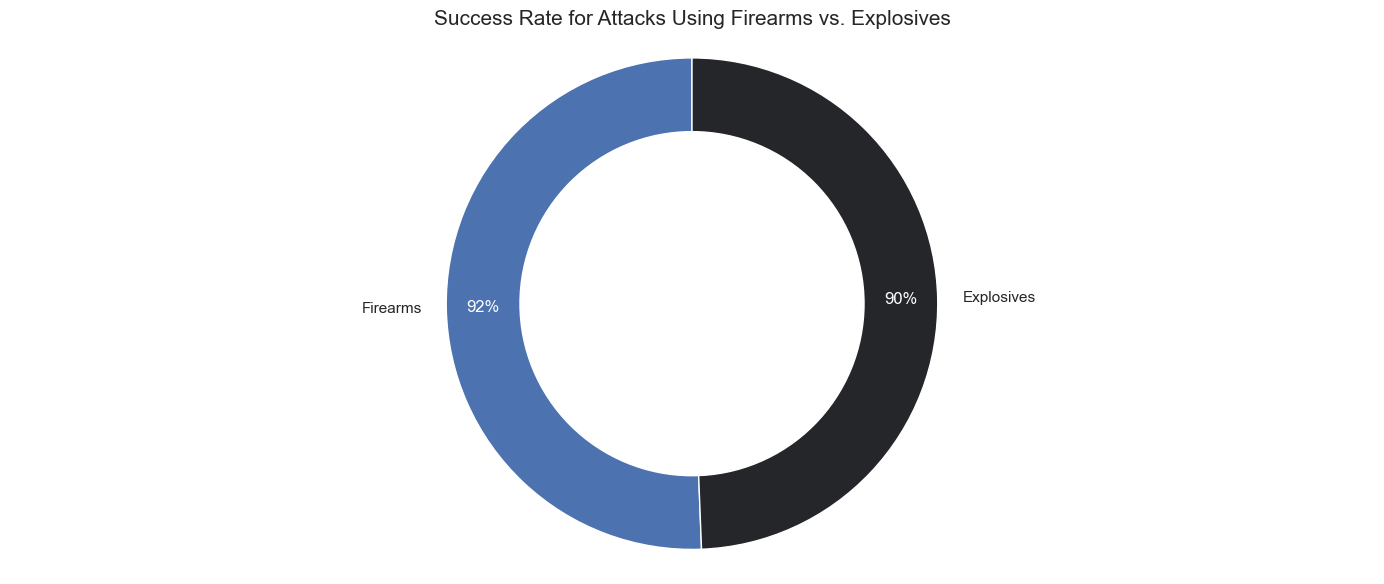

In [1260]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Filter the DataFrame for firearms and explosives
firearms_attacks = df[df['weapon_type'].str.contains('Firearms', case=False, na=False)]
explosives_attacks = df[df['weapon_type'].str.contains('Explosives', case=False, na=False)]

# Calculate success rates
firearms_success_rate = firearms_attacks['success'].mean() * 100  # Convert to percentage
explosives_success_rate = explosives_attacks['success'].mean() * 100  # Convert to percentage

# Prepare data for visualization
success_rates = pd.DataFrame({
    'Weapon Type': ['Firearms', 'Explosives'],
    'Success Rate (%)': [firearms_success_rate, explosives_success_rate]
})

# Create a donut chart
plt.figure(figsize=(14, 6))

# Create wedges
wedges, texts, autotexts = plt.pie(success_rates['Success Rate (%)'], 
                                   labels=success_rates['Weapon Type'], 
                                   autopct='', startangle=90, pctdistance=0.85,
                                   colors=sns.color_palette(palette, len(success_rates)))

# Draw a circle in the center to create a donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Draw the percentages on the donut chart
for i, p in enumerate(autotexts):
    p.set_text(f'{success_rates["Success Rate (%)"].values[i]:.0f}%')
    p.set_color('white')  # Set text color to white for better readability

# Set title
plt.title('Success Rate for Attacks Using Firearms vs. Explosives', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()  # Adjust the layout
plt.show()

- ### **Are suicide bombings more effective than other methods?**  

In [1298]:
df.columns

Index(['eventid', 'year', 'month', 'day', 'region', 'city', 'location', 'lat',
       'long', 'attack_type', 'suicide', 'success', 'weapon_type',
       'weapon_subtype', 'weapon_detail', 'target_type', 'target_subtype',
       'target', 'killed', 'wounded', 'nationality', 'group_name',
       'terr_killed', 'terr_wounded', 'claim_mode', 'propextent', 'summary',
       'motive', 'extended', 'date', 'day_of_week', 'month_name',
       'total_casualties', 'city_type'],
      dtype='object')

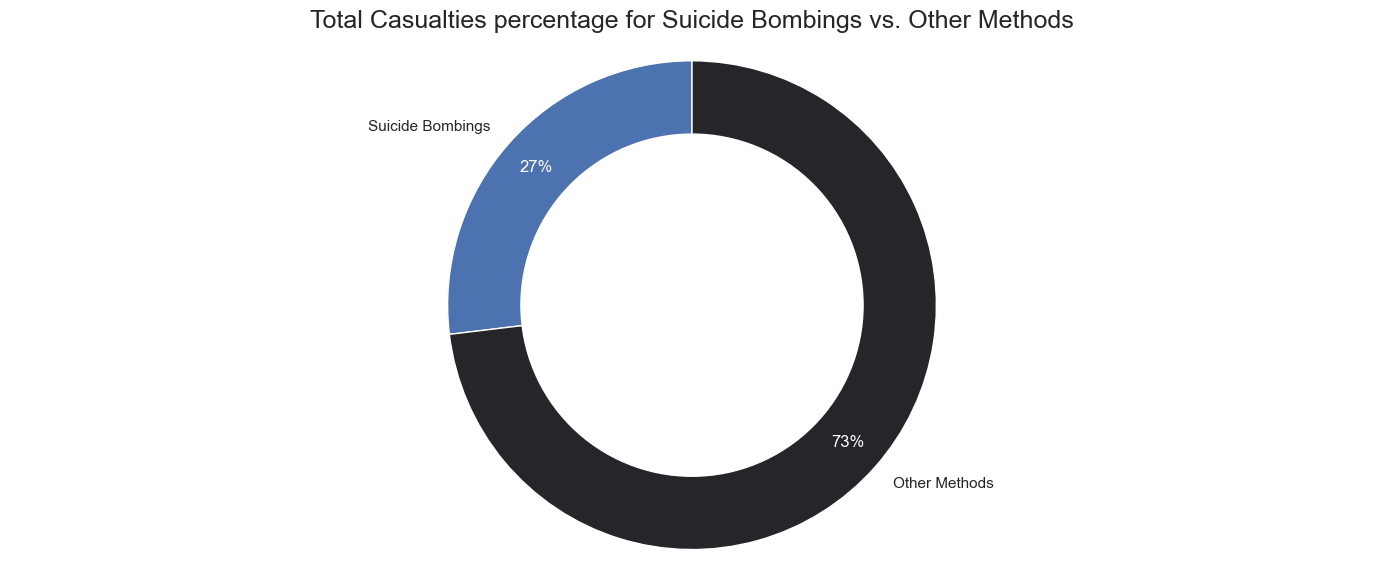

In [1261]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Filter the DataFrame for suicide bombings and other methods
suicide_bombings = df[df['suicide'] == 1]
other_methods = df[df['suicide'] == 0]

# Calculate total casualties
total_casualties = pd.DataFrame({
    'Method': ['Suicide Bombings', 'Other Methods'],
    'Total Casualties': [suicide_bombings['total_casualties'].sum(), 
                         other_methods['total_casualties'].sum()]
})

# Calculate percentages
total_casualties['Percentage'] = (total_casualties['Total Casualties'] / total_casualties['Total Casualties'].sum()) * 100

# Create a donut chart
plt.figure(figsize=(14, 6))

# Create wedges
wedges, texts, autotexts = plt.pie(total_casualties['Percentage'], 
                                   labels=total_casualties['Method'], 
                                   autopct='', startangle=90, pctdistance=0.85,
                                   colors=sns.color_palette(palette, len(total_casualties)))

# Draw a circle in the center to create a donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Draw the percentages on the donut chart
for i, p in enumerate(autotexts):
    p.set_text(f'{total_casualties["Percentage"].values[i]:.0f}%')  # Show percentage with one decimal place
    p.set_color('white')  # Set text color to white for better readability

# Set title
plt.title('Total Casualties percentage for Suicide Bombings vs. Other Methods', fontsize=18)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()  # Adjust the layout
plt.show()


- ### **What is the Correlation Between Attack Type and Weapon Used?**

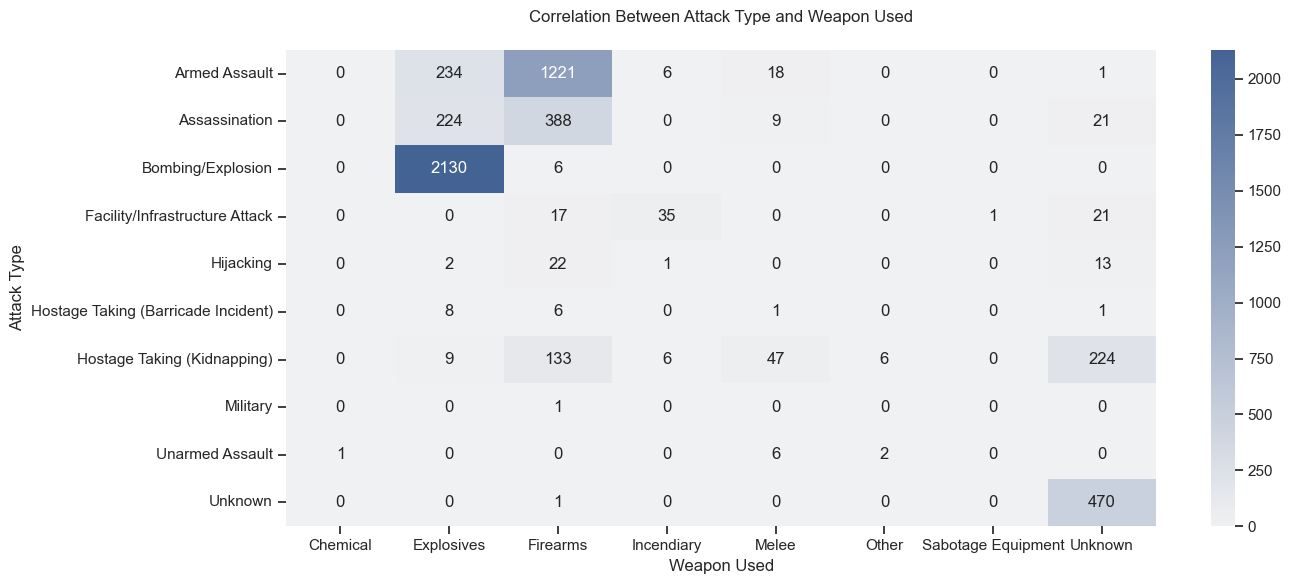

In [1262]:
# Set the Seaborn theme and color palette
sns.set_theme(style='ticks')
palette = sns.color_palette('dark:b_r')
# Create a crosstab of attack type and weapon type
attack_weapon_crosstab = pd.crosstab(df['attack_type'], df['weapon_type'])

# Create a custom colormap using the specified palette
cmap = sns.light_palette(palette[1], as_cmap=True)

plt.figure(figsize=(14, 6))
sns.heatmap(attack_weapon_crosstab, cmap=cmap, annot=True, fmt='d')
plt.title('Correlation Between Attack Type and Weapon Used', pad=20)
plt.xlabel('Weapon Used')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

- ### **What are the percentages of different suicide attacks types?**

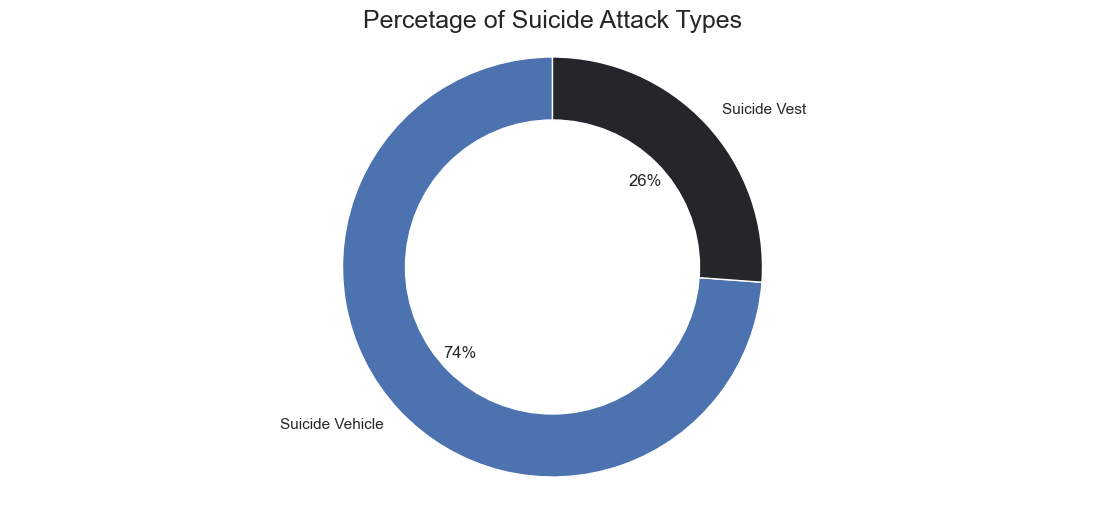

In [1263]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Filter for suicide attacks
suicide_attacks = df[df['suicide'] == 1]

# Count weapon types used in suicide attacks
weapon_counts = suicide_attacks['weapon_subtype'].value_counts()

# Calculate percentages
weapon_percentages = (weapon_counts / weapon_counts.sum()) * 100

# Visualization - Pie chart
plt.figure(figsize=(14, 6))
plt.pie(weapon_percentages, labels=weapon_percentages.index, 
        autopct='%1.0f%%', startangle=90, 
        colors=sns.color_palette(palette, len(weapon_percentages)))

# Draw a circle in the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set title and make the pie chart circular
plt.title('Percetage of Suicide Attack Types', fontsize=18)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

- ### **What is the percentage distribution of weapon subtypes used in assassination attacks?**

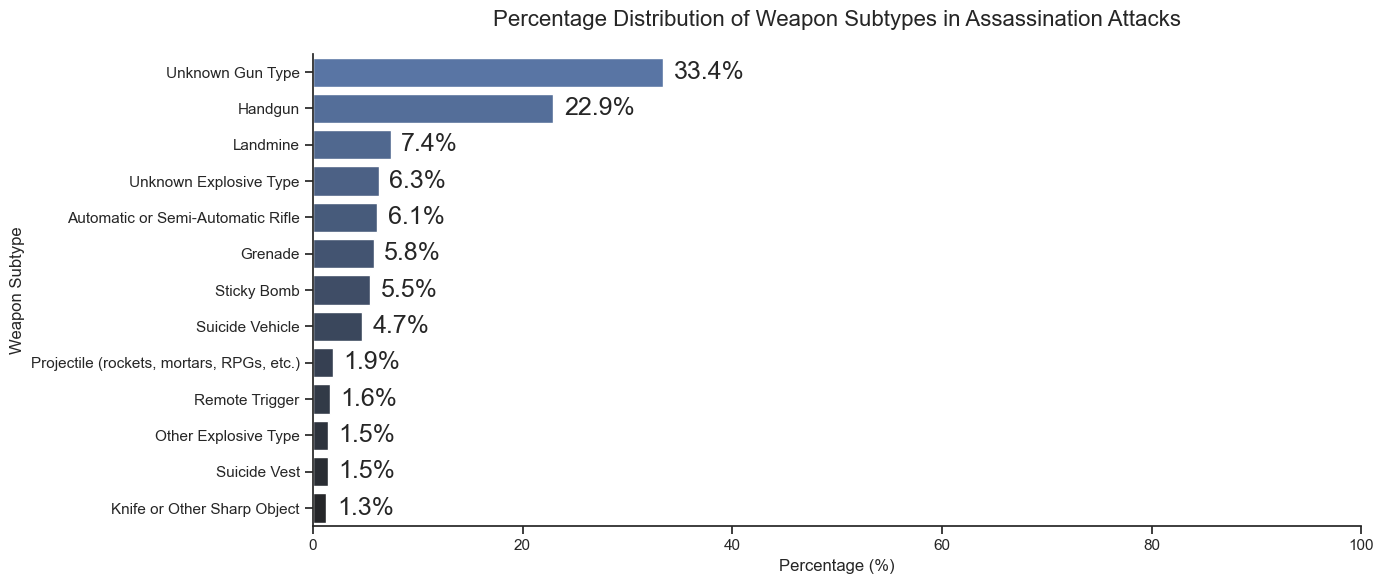

In [1264]:
# Set the Seaborn theme
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Filter for assassination attacks
assassination_attacks = df[df['attack_type'] == 'Assassination']

# Count weapon subtypes used in assassination attacks
weapon_counts = assassination_attacks['weapon_subtype'].value_counts().head(13)

# Calculate percentages
weapon_percentages = (weapon_counts / weapon_counts.sum()) * 100

# Visualization - Horizontal Bar Chart
plt.figure(figsize=(14, 6))
sns.barplot(y=weapon_percentages.index, x=weapon_percentages.values, palette=palette)

# Set titles and labels
plt.title('Percentage Distribution of Weapon Subtypes in Assassination Attacks', pad=20, fontsize=16)
plt.ylabel('Weapon Subtype')
plt.xlabel('Percentage (%)')
plt.xlim(0, 100)  # Set x-axis limits to [0, 100]

# Show the percentage values on the right of the bars
for index, value in enumerate(weapon_percentages):
    plt.text(value + 1, index, f"{value:.1f}%", ha='left', va='center', fontsize=18)

plt.tight_layout()  # Adjust the layout
sns.despine()
plt.show()

### **7. Casualty Analysis**

- ### **What are the total casualties by region and city?** 

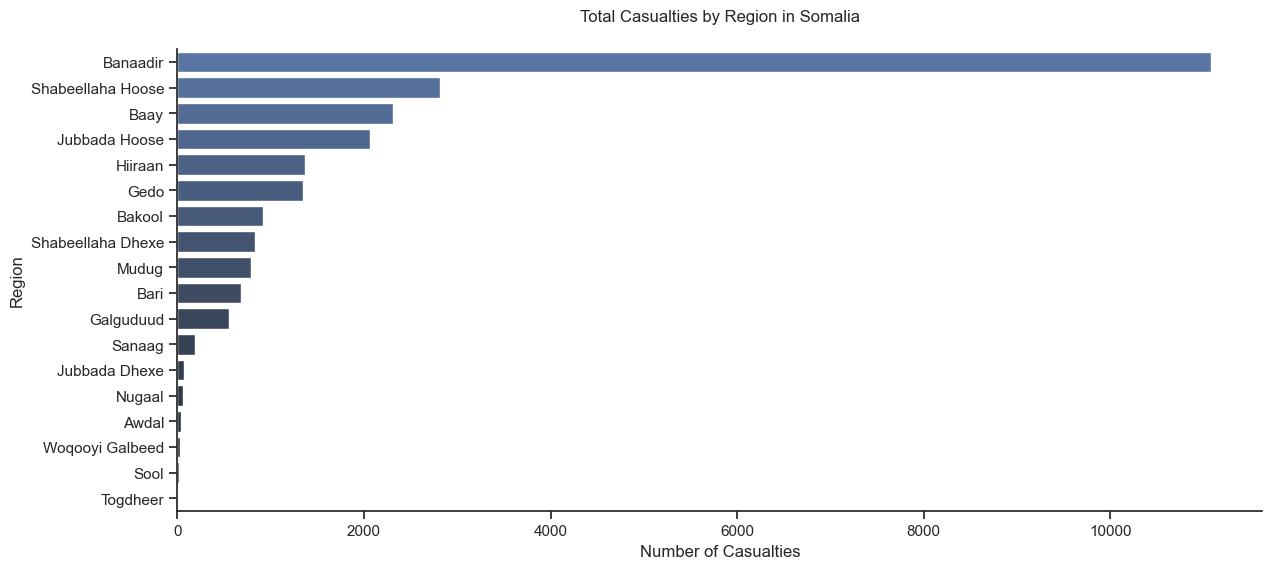

In [1299]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'
df_reg = df[df['region'] != 'Unknown']
# Group by region and calculate the total casualties for each region
region_casualties = df_reg.groupby('region')['total_casualties'].sum().reset_index().sort_values(by='total_casualties', ascending=False)

# Visualization
plt.figure(figsize=(14, 6))

# Create the bar plot for total casualties by region
sns.barplot(x='total_casualties', y='region', data=region_casualties, palette=palette)

# Set plot title and labels
plt.title('Total Casualties by Region in Somalia', pad=20)
plt.xlabel('Number of Casualties')
plt.ylabel('Region')
plt.xticks(rotation=0)
sns.despine()
# Show the plot
plt.show()

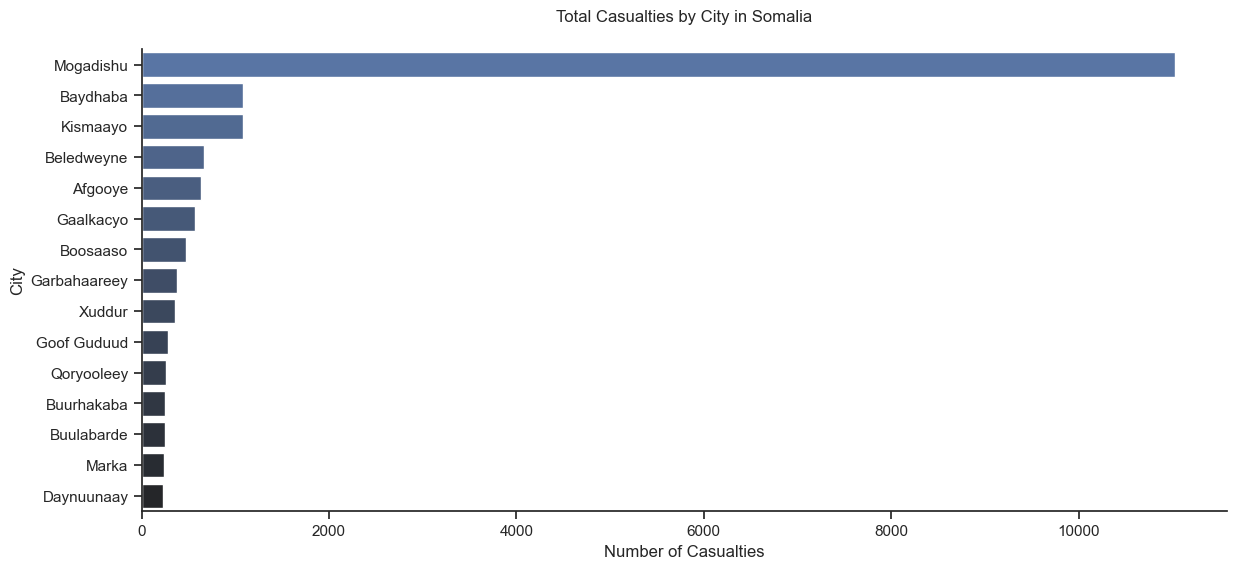

In [1266]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'
df_cit = df[df['city']!= 'Unknown']
# Group by region and calculate the total casualties for each region
city_casualties = df_cit.groupby('city')['total_casualties'].sum().reset_index().sort_values(by='total_casualties', ascending=False)
city_casualties = city_casualties.head(15)
# Visualization
plt.figure(figsize=(14, 6))

# Create the bar plot for total casualties by region
sns.barplot(x='total_casualties', y='city', data=city_casualties, palette=palette)

# Set plot title and labels
plt.title('Total Casualties by City in Somalia', pad=20)
plt.xlabel('Number of Casualties')
plt.ylabel('City')
plt.xticks(rotation=0)
sns.despine()
# Show the plot
plt.show()

- ### **What percentage of attacks result in casualties?**  

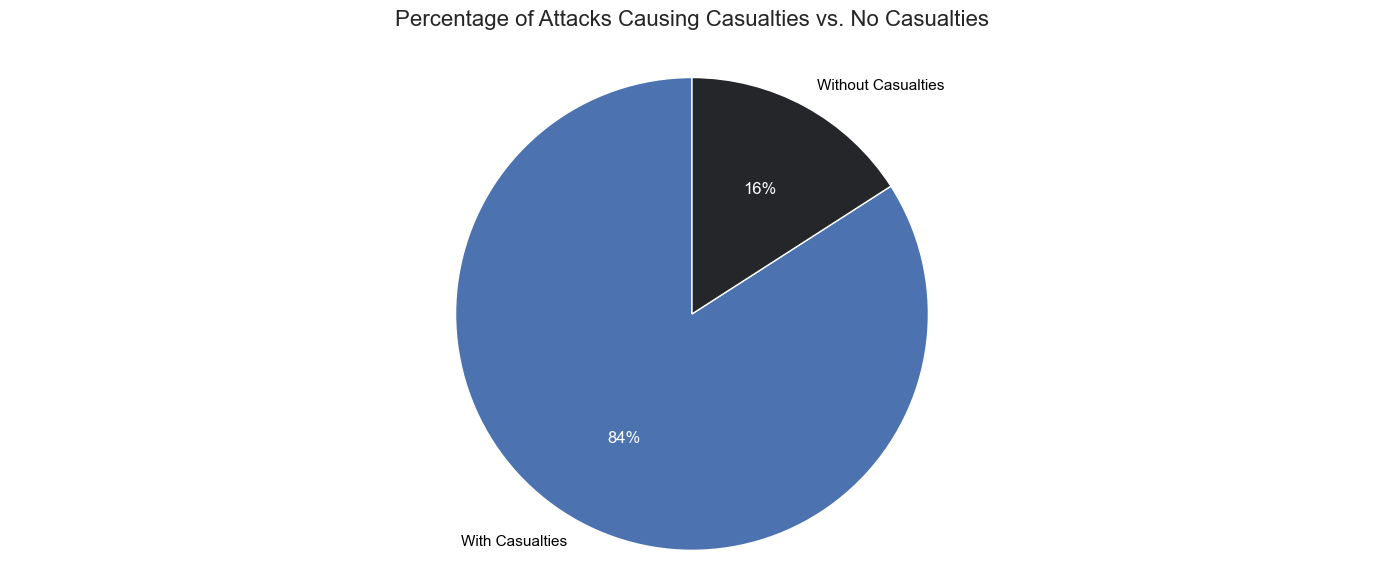

In [1267]:
# Set the Seaborn theme
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Calculate the total number of attacks
total_attacks = len(df)

# Count attacks that resulted in casualties
attacks_with_casualties = len(df[df['total_casualties'] > 0])

# Calculate the percentage of attacks that resulted in casualties and those that did not
casualty_percentage = (attacks_with_casualties / total_attacks) * 100
no_casualty_percentage = 100 - casualty_percentage

# Create data for the pie chart
casualty_data = [casualty_percentage, no_casualty_percentage]
labels = ['With Casualties', 'Without Casualties']

# Visualization - Pie chart
plt.figure(figsize=(14, 6))
wedges, texts, autotexts = plt.pie(
    casualty_data, 
    labels=labels, 
    autopct='%1.0f%%', 
    startangle=90, 
    colors=sns.color_palette(palette, len(casualty_data))
)

# Set text properties
for text in texts:
    text.set_color('black')  # Set labels to black

for autotext in autotexts:
    autotext.set_color('white')  # Set percentage text to white

# Title and aspect ratio
plt.title('Percentage of Attacks Causing Casualties vs. No Casualties', pad=20, fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()  # Adjust layout
plt.show()

- ### **How do casualty rates vary by attack type?**  

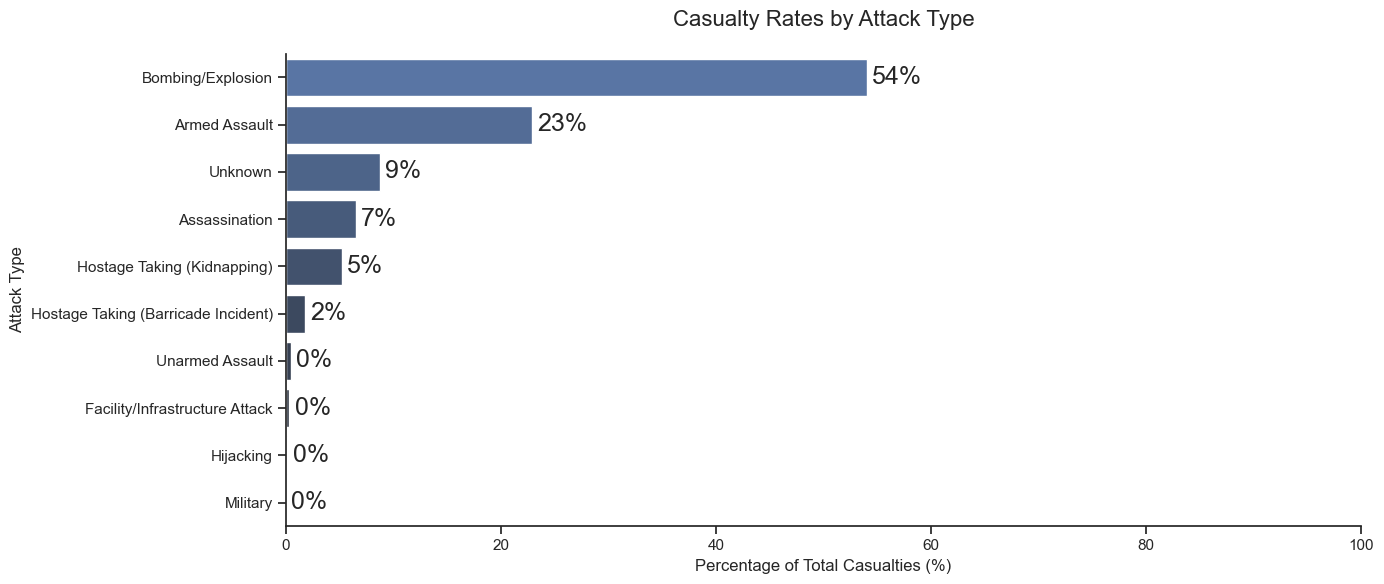

In [1268]:
# Set the Seaborn theme
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Calculate total casualties by attack type
casualties_by_attack_type = df.groupby('attack_type')['total_casualties'].sum().sort_values(ascending=False)

# Calculate the percentage of total casualties by attack type
casualty_percentage = (casualties_by_attack_type / casualties_by_attack_type.sum()) * 100

# Visualization - Horizontal Bar Chart
plt.figure(figsize=(14, 6))
sns.barplot(x=casualty_percentage.values, y=casualty_percentage.index, palette=palette)

# Set titles and labels
plt.title('Casualty Rates by Attack Type', pad=20, fontsize=16)
plt.xlabel('Percentage of Total Casualties (%)')
plt.ylabel('Attack Type')

# Display percentage values on the bars
for index, value in enumerate(casualty_percentage.values):
    plt.text(value + 0.5, index, f'{value:.0f}%', va='center', fontsize=18)

plt.xlim(0, 100)  # Set x-axis limit to [0, 100]
plt.tight_layout()  # Adjust the layout
sns.despine()
plt.show()

- ### **Are there any Nociable Terrorism attacks with high casualties?**  

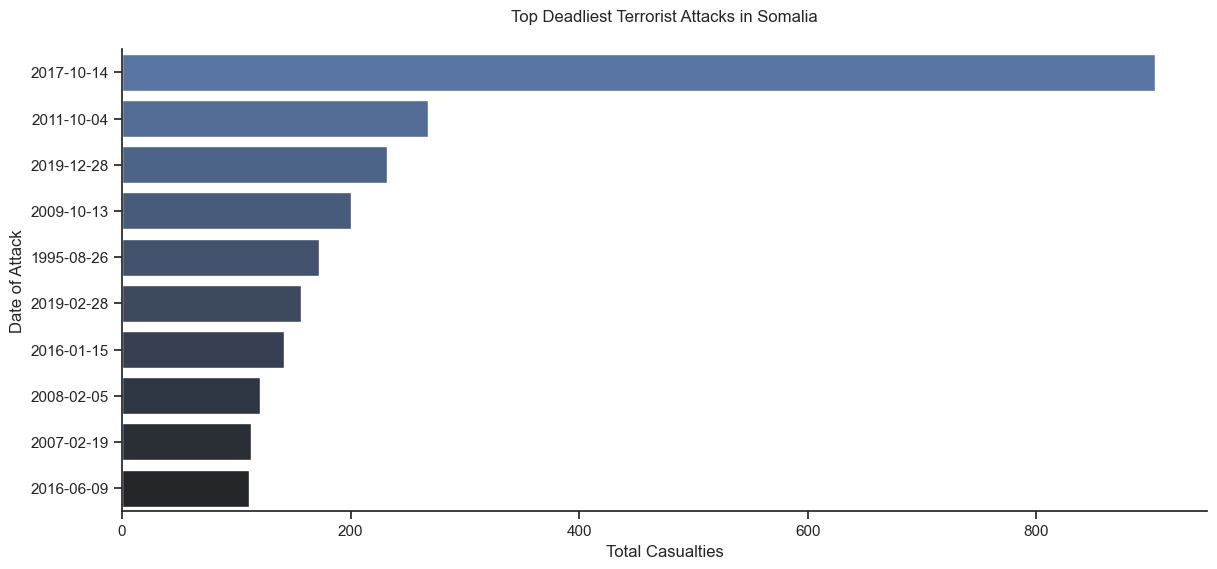

In [1269]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Find the deadliest attacks by sorting the total casualties
deadliest_attacks = df[['eventid', 'date', 
                        'city', 'region', 'total_casualties']].sort_values(by='total_casualties', 
                                                                           ascending=False).head(10)
# Visualization: Bar chart of the deadliest attacks
plt.figure(figsize=(14, 6))
sns.barplot(data=deadliest_attacks, x='total_casualties', y='date', palette=palette)
plt.title('Top Deadliest Terrorist Attacks in Somalia', pad=20)
plt.xlabel('Total Casualties')
plt.ylabel('Date of Attack')
sns.despine()
plt.show()

- ### **Terrorism attacks with highest killed people**

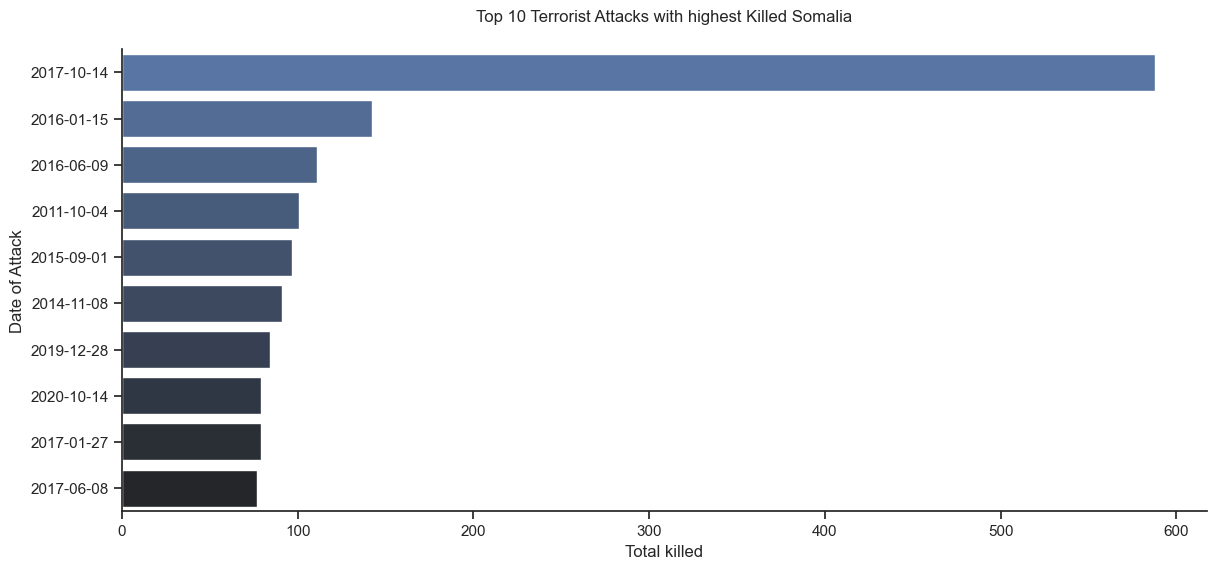

In [1270]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Find the deadliest attacks by sorting the total casualties
deadliest_attacks = df[['eventid', 'date', 
                        'city', 'region', 'killed']].sort_values(by='killed', 
                                                                           ascending=False).head(10)
# Visualization: Bar chart of the deadliest attacks
plt.figure(figsize=(14, 6))
sns.barplot(data=deadliest_attacks, x='killed', y='date', palette=palette)
plt.title('Top 10 Terrorist Attacks with highest Killed Somalia', pad=20)
plt.xlabel('Total killed')
plt.ylabel('Date of Attack')
sns.despine()
plt.show()

- ### **Terrorism attacks with highest wounded people**

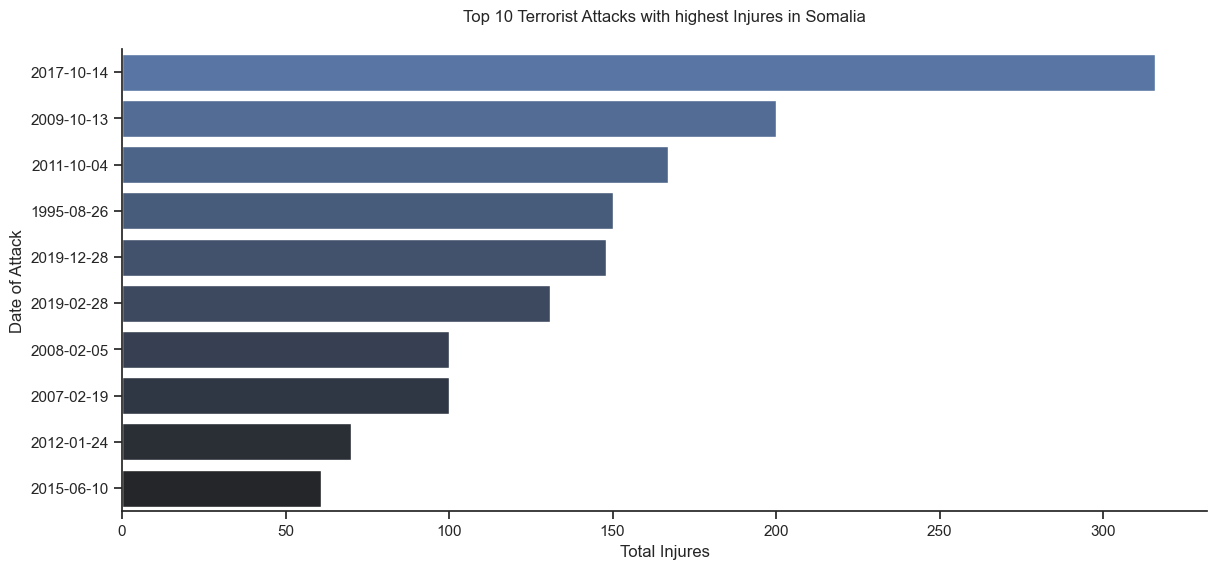

In [1271]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Find the deadliest attacks by sorting the total casualties
deadliest_attacks = df[['eventid', 'date', 
                        'city', 'region', 'wounded']].sort_values(by='wounded', 
                                                                           ascending=False).head(10)
# Visualization: Bar chart of the deadliest attacks
plt.figure(figsize=(14, 6))
sns.barplot(data=deadliest_attacks, x='wounded', y='date', palette=palette)
plt.title('Top 10 Terrorist Attacks with highest Injures in Somalia', pad=20)
plt.xlabel('Total Injures')
plt.ylabel('Date of Attack')
sns.despine()
plt.show()

- ### **Top 5 highest killed by year in Somalia**

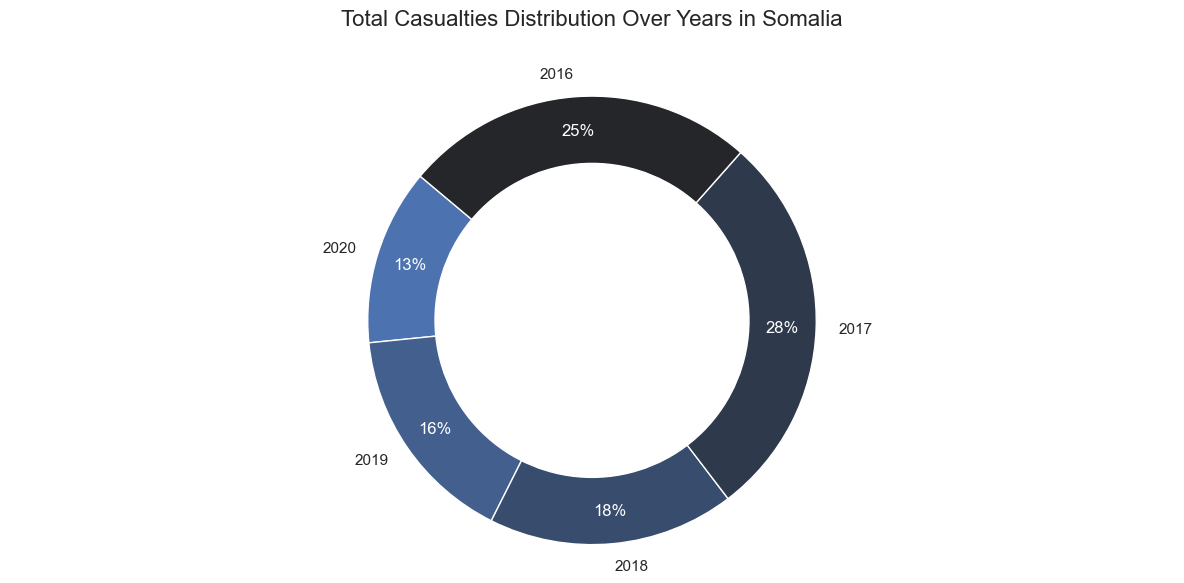

In [1272]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Prepare the Data
affected = df.groupby(['year'])['total_casualties'].sum().sort_index(ascending=False).reset_index().head()

# Calculate percentages
total_casualties = affected['total_casualties'].sum()
affected['percentage'] = (affected['total_casualties'] / total_casualties) * 100

# Create the donut chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette(palette, n_colors=len(affected))

# Draw the pie chart
wedges, texts, autotexts = plt.pie(affected['total_casualties'], 
                                    labels=affected['year'], 
                                    autopct='',  # Remove default autopct to customize later
                                    startangle=140, 
                                    colors=colors, 
                                    pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add percentages manually for better control over text appearance
for i, a in enumerate(autotexts):
    percentage = f'{affected["percentage"].iloc[i]:.0f}%'
    a.set_text(percentage)  # Set the percentage text
    a.set_color('white')     # Change the text color to white
    a.set_fontsize(12)       # Optionally, adjust font size for better visibility

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.title('Total Casualties Distribution Over Years in Somalia', fontsize=16, pad=35)
plt.tight_layout()  # Adjust layout to make room for the donut shape
plt.show()

- ### **Percentage of casualties in by suicide and non suicide attacks**

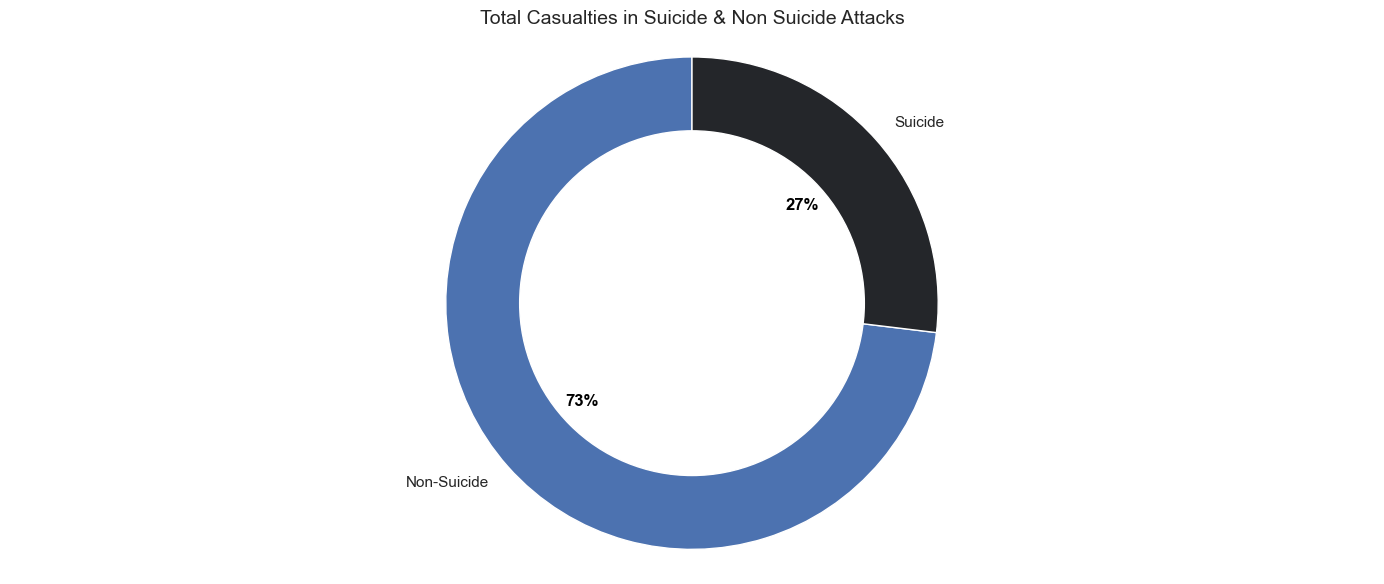

In [1273]:
# Set the Seaborn theme and palette
sns.set_theme(style='ticks')
palette = 'dark:b_r'

# Group by suicide flag and sum total casualties
suicide_casualties = df.groupby('suicide')['total_casualties'].sum().reset_index()
# Map boolean to labels for better readability
suicide_casualties['suicide'] = suicide_casualties['suicide'].map({0: 'Non-Suicide', 1: 'Suicide'})
# Prepare data for the donut chart
sizes = suicide_casualties['total_casualties']
labels = suicide_casualties['suicide']

# Set up the figure
plt.figure(figsize=(14, 6))
# Create a pie chart
wedges, texts, autotexts = plt.pie(sizes, labels=labels, 
                                   autopct='%1.0f%%', startangle=90, 
                                   colors=sns.color_palette(palette, len(labels)))
# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie chart is a circle
plt.axis('equal')  
plt.title("Total Casualties in Suicide & Non Suicide Attacks", fontsize=14)
plt.setp(autotexts, size=12, weight="bold", color="black")
# Show the plot
plt.tight_layout()
plt.show()

- ### **Most Targeted hotels in Mogadishu**

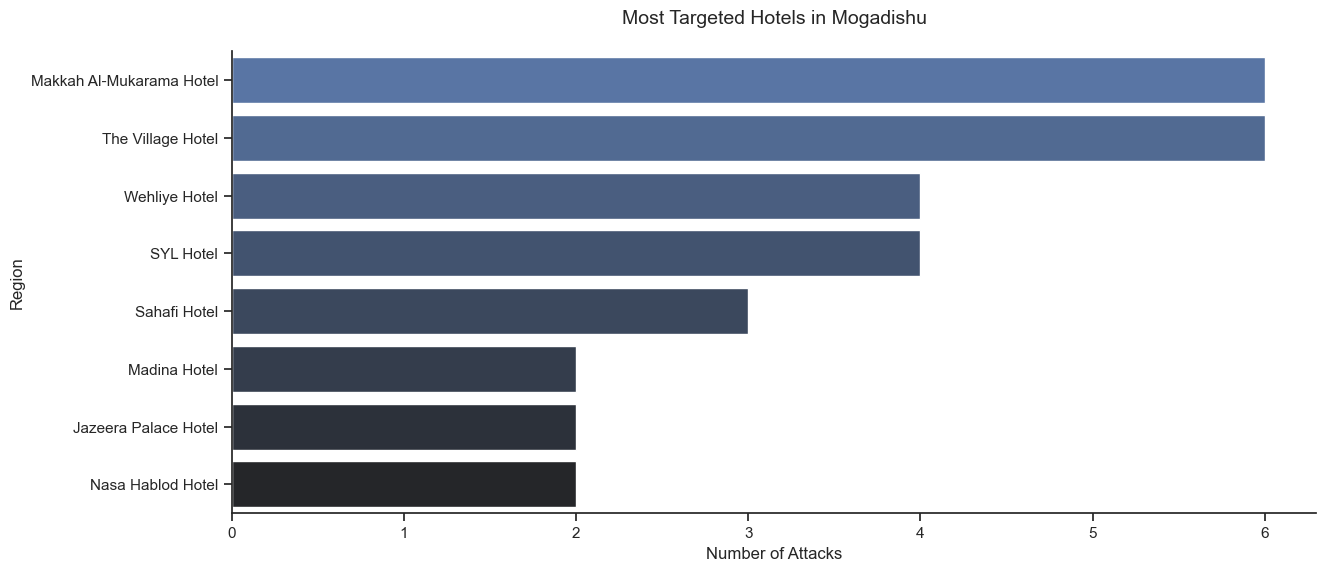

In [1274]:
sns.set_theme(style='ticks')
palette = 'dark:b_r'
# Filter the DataFrame for attacks targeting hotels
hotel_attacks = df[df['target_subtype'] == 'Hotel/Resort']

# Count attacks by region (state or city)
vulnerable_regions = hotel_attacks['target'].value_counts().head(8)  # Change 'state' to 'city' if needed

# Visualization: Bar chart of vulnerable regions
plt.figure(figsize=(14, 6))
sns.barplot(x=vulnerable_regions.values, y=vulnerable_regions.index, palette=palette)
plt.title('Most Targeted Hotels in Mogadishu', pad=20, fontsize=14)
plt.xlabel('Number of Attacks')
plt.ylabel('Region')
sns.despine()
plt.show()

In [1300]:
# Group by region and count the number of attacks
region_attack_counts = df.groupby('region').size().reset_index(name='attack_count')

# Calculate the attack_percentage of attacks by region
total_attacks = region_attack_counts['attack_count'].sum()
region_attack_counts['attack_percentage'] = (region_attack_counts['attack_count'] / total_attacks) * 100

# Sort the DataFrame by attack_percentage in descending order
region_attack_counts = region_attack_counts.sort_values(by='attack_percentage', ascending=False)

# Round attack_percentage to whole numbers and add attack_percentage sign
region_attack_counts['attack_percentage'] = region_attack_counts['attack_percentage'].round(0).astype(int).astype(str) + '%'

# Drop the 'attack_count' column
region_attack_counts = region_attack_counts[['region', 'attack_percentage']]

# Display the top 10 results
region_attack_counts.head(10)

,region,attack_percentage
3,Banaadir,38%
14,Shabeellaha Hoose,16%
9,Jubbada Hoose,8%
1,Baay,7%
7,Hiiraan,7%
6,Gedo,6%
13,Shabeellaha Dhexe,4%
4,Bari,3%
10,Mudug,3%
5,Galguduud,3%
